In [11]:
# WRITTEN BY ALAN LI
# NASA AMES LABORATORY FOR ADVANCED SENSING (LAS)
# Last edited: April 26, 2018
%matplotlib notebook

import sys
sys.path.append("./utils/") # Adds higher directory to python modules path.
import random
import numpy as np
import pydensecrf.densecrf as dcrf
import cv2
import glob, os
from collections import Counter

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
from collections import Counter
import logging
import yaml
import json
from PIL import Image as pil_image
from osgeo import gdal, ogr, osr

import tensorflow as tf
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import loadcoraldata_utils as coralutils
import keras
import keras.backend as K
from keras.models import Model, Sequential, load_model
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing.image import img_to_array
from keras.callbacks import Callback
from keras.utils.np_utils import to_categorical
from NeMO_models import FCN
from NeMO_losses import charbonnierLoss
import NeMO_layers
import NeMO_encoders
from NeMO_generator import NeMOImageGenerator, ImageSetLoader
from NeMO_callbacks import CheckNumericsOps, WeightsSaver

num_cores = 4
num_GPU = 1
num_CPU = 1

global _SESSION
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
_SESSION = tf.Session(config=config)
K.set_session(_SESSION)

%matplotlib notebook

# model = load_model('./tmp/RefineMask_DANN256_v2.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 'charbonnierLoss': charbonnierLoss, 'GradientReversal':NeMO_layers.GradientReversal})
model = load_model('./tmp/RefineMask_Jarrett256_RGB_NIR_spectralshift.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 'charbonnierLoss': charbonnierLoss})
# cloudmodel = load_model('./tmp/RefineMask_Cloud.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 'charbonnierLoss': charbonnierLoss})

cloudmodel = load_model('./tmp/VGG16DeepLab_FijiCloudShadowMask256_4channel_allmosaics.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 'charbonnierLoss': charbonnierLoss})

./utils/loadcoraldata_utils.py:223: RuntimeWarning: divide by zero encountered in long_scalars
  self.consolclass_weights = dict((k, (self.truthimage_consolidated.shape[0]*self.truthimage_consolidated.shape[1])/(self.truthimage_consolidated==newclassdict[k]).sum()) for k in newclassdict)


{1: 'Coral', 2: 'Sediment', 3: 'Beach', 4: 'Seagrass', 5: 'Terrestrial vegetation', 6: 'Deep water', 7: 'Clouds', 8: 'Wave breaking', 9: 'Other or Unknown'}
(5012, 5633, 8)


<IPython.core.display.Javascript object>


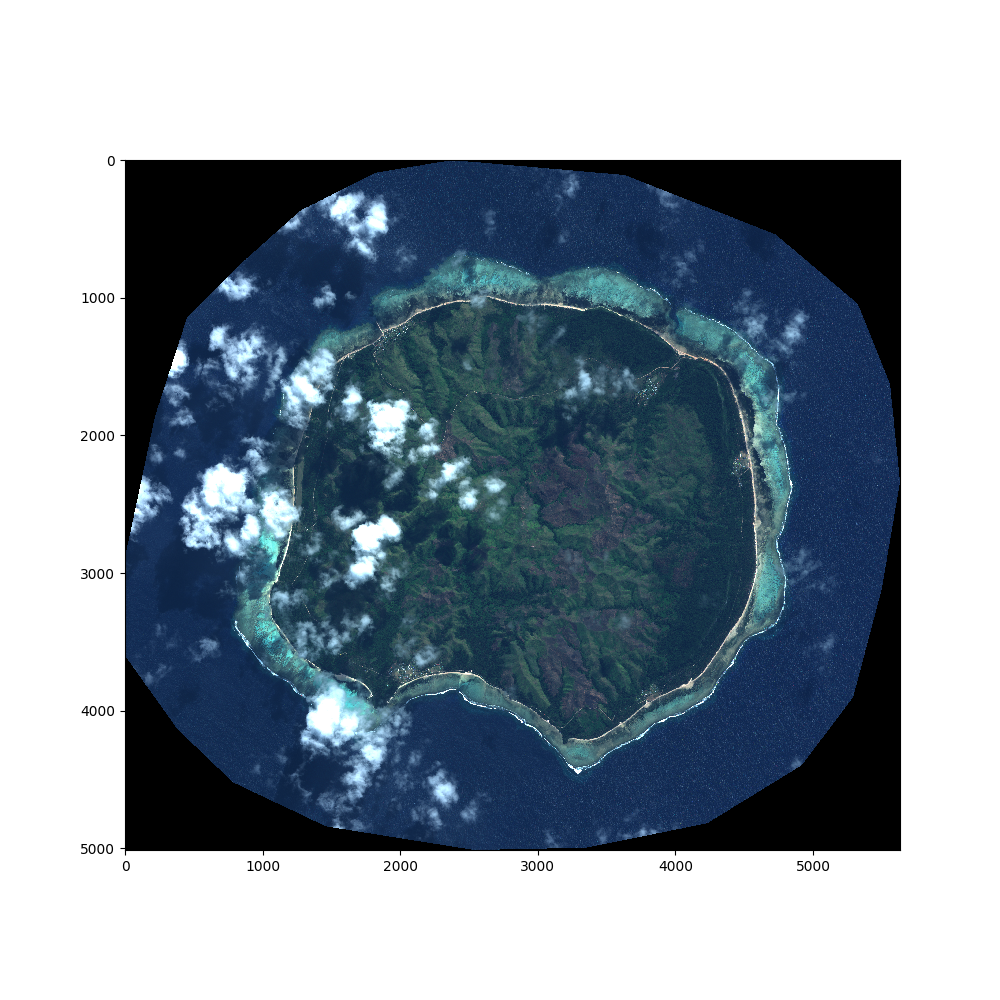

maximums: [403.73022461 577.70861816 416.92147827 364.49139404 476.07369995
 301.949646   296.68740845 185.54107666]
[71.67579651 61.89735413 43.75733185 30.02758026 21.67448616 28.80087852
 19.70253944  6.98337603]


In [22]:
# Notes on Transects:
# Mosaic 1-3 Cicia
# Mosaic 4-7 Fulaga (4:80% east, 7: Spectrally poor)
# Mosaic 8-13 Kobara(8: 20% west, 9: 20% left, 12:70% east)
# Mosaic 14 Mago
# Mosaic 15-18 Matuka
# Mosaic 19-22 Moala (19: 10% Very Incomplete, 20: 70% east, 21: 30% west, 22: 20% South Spectrally poor)
# Mosaic 23-25 Nayau 
# Mosaic 26-32 Totoya (26: 80% west, 27: 70% west, 28: 20% east, 29: 60% east, 30: 30% east, 31: 80% west, 32: 80% west)
# Mosaic 33 Tuvuca
# Mosaic 34-38 Vanua Balavu # Way too big
# Mosaic 39-41 Vanua Vatu (40: 50% east, 41: 50% west)

# Test export of patches from gdal
imgpath = '/home/shared/NeMO-Net Data/processed_Fiji_files/mosaiced_001.TIF'
imgpath_original = '/home/shared/NeMO-Net Data/KSLOF-CICIA-FIJI/Cicia_Satellite_image_mosaic_KSLOF.tif'
truthpath = '/home/shared/NeMO-Net Data/KSLOF-CICIA-FIJI/Cicia_Habitat_classes_raster_KSLOF.tif'
# imgpath = '/home/shared/NeMO-Net Data/processed_Fiji_files/mosaiced_006.TIF'
# imgpath_original = '/home/shared/NeMO-Net Data/KSLOF-FULAGA_Fiji/Fulaga_Satellite_image_mosaic_KSLOF.tif'
# truthpath = '/home/shared/NeMO-Net Data/KSLOF-FULAGA_Fiji/Fulaga_Habitat_classes_raster_KSLOF.tif'

# imgpath = '/home/shared/NeMO-Net Data/processed_Fiji_files/mosaiced_011.TIF'
# imgpath_original = '/home/shared/NeMO-Net Data/KSLOF-KOBARA-Fiji/Kobara_Satellite_image_mosaic_KSLOF.tif'
# truthpath = '/home/shared/NeMO-Net Data/KSLOF-KOBARA-Fiji/Kobara_Habitat_classes_raster_KSLOF.tif'

output_trainpath = '../Images/Fiji_Training_Patches/'
output_trainrefpath = '../Images/Fiji_TrainingRef_Patches/'
output_trainfilename = 'rastertrain.txt'
output_validpath = '../Images/Fiji_Valid_Patches/'
output_validrefpath = '../Images/Fiji_ValidRef_Patches/'
output_validfilename = 'rastervalid.txt'
jsonpath = './utils/CoralClasses.json'

with open(jsonpath) as json_file:
    json_data = json.load(json_file)

Fiji = coralutils.CoralData(imgpath, Truthpath=truthpath, truth_key=json_data["Fiji_ClassDict"], load_type="raster")
Fiji.Consolidate_classes(newclassdict=json_data["L3_ClassDict"], transferdict=json_data["Fiji2L3_Dict"])
FijiTruth_24classes = np.copy(Fiji.truthimage_consolidated)
Fiji.Consolidate_classes(newclassdict=json_data["VedConsolidated_ClassDict"], transferdict=json_data["L32VedConsolidated_Dict"])
FijiTruth_Ved = np.copy(Fiji.truthimage_consolidated)

Fiji_original = coralutils.CoralData(imgpath_original, Truthpath=truthpath, truth_key=json_data["Fiji_ClassDict"], load_type="raster")
Fiji_original.Consolidate_classes(newclassdict=json_data["L3_ClassDict"], transferdict=json_data["Fiji2L3_Dict"])
Fiji_original.Consolidate_classes(newclassdict=json_data["MajorConsolidated_ClassDict"], transferdict=json_data["L32MajorConsolidated_Dict"])
FijiTruth_Major = np.copy(Fiji_original.truthimage_consolidated)

labelkey = json_data["VedConsolidated_ClassDict"]
class_indices_rev_Ved = dict((v,k) for k,v in labelkey.items()) #flip k,v
labelkey_24classes = json_data["L3_ClassDict"]
class_indices_rev_24classes = dict((v,k) for k,v in labelkey_24classes.items()) #flip k,v
class_indices_rev = dict((v,k) for k,v in labelkey.items()) #flip k,v
print(class_indices_rev)

# print(Fiji.consolclass_weights)
# print(Fiji.consolclass_count)

with open("init_args - Jarrett.yml", 'r') as stream:
    try:
        init_args = yaml.load(stream)
    except yaml.YAMLError as exc:
        print(exc)

train_loader = ImageSetLoader(**init_args['image_set_loader']['train'])
val_loader = ImageSetLoader(**init_args['image_set_loader']['val'])

# if train_loader.color_mode == 'rgb':
#     num_channels = 3
# elif train_loader.color_mode == '8channel':
#     num_channels = 8
num_channels = 4
y = train_loader.target_size[1]
x = train_loader.target_size[0]

pixel_mean = 100*np.ones(num_channels)
pixel_std = 100*np.ones(num_channels)
# datagen = NeMOImageGenerator(image_shape = (y,x,num_channels),
#     image_resample=True, pixelwise_center=True,
#     pixel_mean=pixel_mean, pixelwise_std_normalization=True,
#     pixel_std=pixel_std)

# train_generator = datagen.flow_from_NeMOdirectory(output_trainpath,
#     target_size=(y,x),
#     color_mode='8channel',
#     passedclasses = labelkey,
#     class_mode = 'categorical',
#     batch_size = 6,
#     shuffle=True)

print(Fiji.image.shape)

patch_R = 255/200*Fiji.image[:,:,4]
patch_G = 255/200*Fiji.image[:,:,2]
patch_B = 255/200*Fiji.image[:,:,1]
patch_R[patch_R > 255] = 255
patch_G[patch_G > 255] = 255
patch_B[patch_B > 255] = 255
Fiji_RGB = np.rollaxis(np.asarray([patch_R, patch_G, patch_B], dtype=np.uint8),0,3)
# Fiji_RGB = np.rollaxis(np.asarray([1/max_R*Fiji.image[:,:,2], 1/max_G*Fiji.image[:,:,1], 1/max_B*Fiji.image[:,:,0]]),0,3)
# print(np.unique(Testtruth))

fig = plt.figure(1,figsize=(10,10))
plt.imshow(Fiji_RGB)
print("maximums:", np.max(np.reshape(Fiji.image,(Fiji.image.shape[0]*Fiji.image.shape[1],Fiji.image.shape[2])),0))
print(Fiji.image[3677,1353,:])

<IPython.core.display.Javascript object>


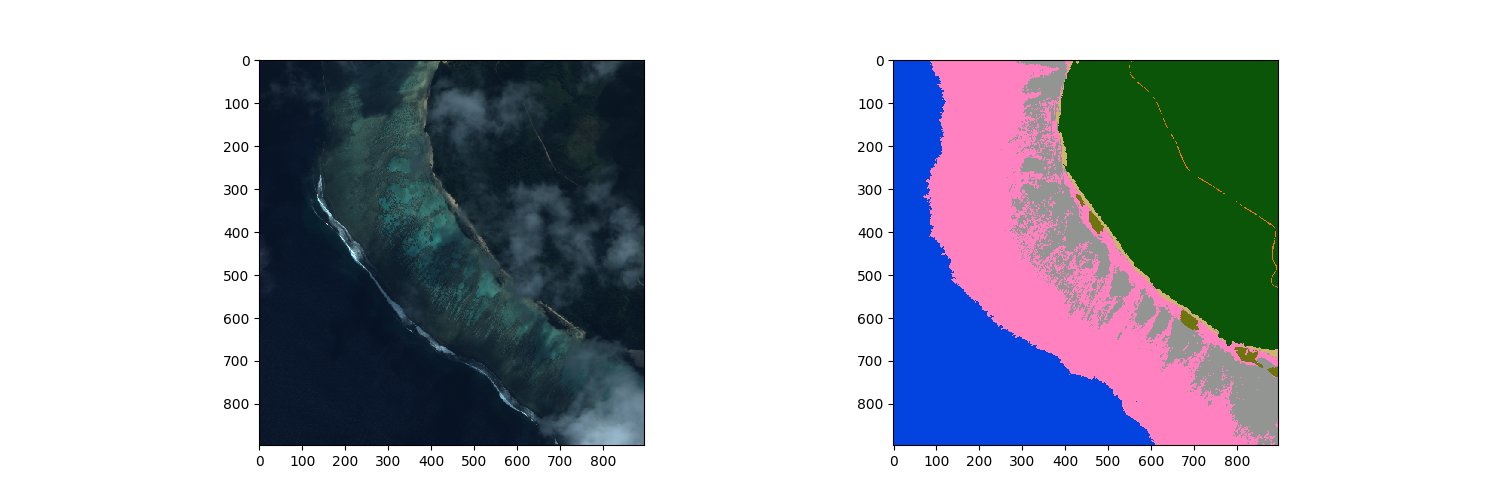

<IPython.core.display.Javascript object>


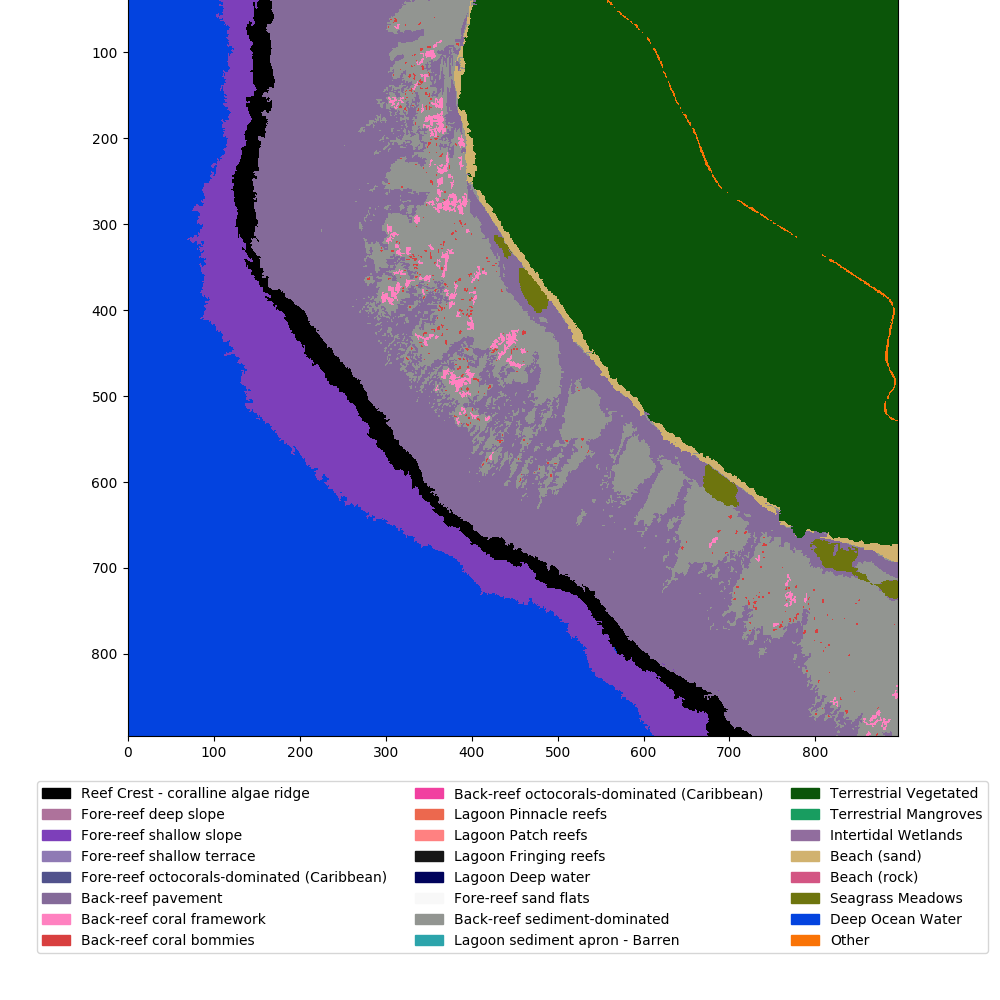

In [21]:
cmap_24classes = colors.ListedColormap(['xkcd:black', '#ae729b', '#7d3fba', '#8f7ab4', '#51528c',
                             '#846a99', 'xkcd:pink', '#d83f3f', '#f140a0', '#ec684e', '#ff8181',
                             '#161616', 'xkcd:dark blue', '#f8f8f8', 'xkcd:grey', '#2ca4ab',
                             'xkcd:forest', '#189d60', '#916d9e', 'xkcd:tan',
                             '#d35583', 'xkcd:olive', 'xkcd:blue', 'xkcd:orange'])
bounds_24classes = [i+0.5 for i in range(25)]
norm_24classes = colors.BoundaryNorm([b+0.5 for b in bounds_24classes], cmap_24classes.N)

cmap_Ved = colors.ListedColormap(['xkcd:pink', 'xkcd:grey', 'xkcd:tan', 'xkcd:olive', 'xkcd:forest', 'xkcd:blue',
                                'xkcd:lilac', 'xkcd:cyan', 'xkcd:orange'])
bounds = [i+0.5 for i in range(10)]
norm = colors.BoundaryNorm([b+0.5 for b in bounds], cmap_Ved.N)

# Southwestern area
# xstart = 1000
# ystart = 3600

# Northern area
xgeo = 253479.0
ygeo = 8040132.0 

xstart = int((xgeo-Fiji.geotransform[0])/Fiji.geotransform[1])
ystart = int((ygeo-Fiji.geotransform[3])/Fiji.geotransform[5])
xlen = 1536
ylen = 768


# xstart = 2400
# ystart = 236

# xstart = 3100 - 256
# ystart = 600 - 256

# southeastern area
# xstart = 3600
# ystart = 3300

# eastern area
# xstart = 4300
# ystart = 2000

# Fulaga good area
# ystart = 3000
# xstart = 200
# ystart = 2200
# xstart = 4400

ystart = 3000
xstart = 600
xlen = 1024
ylen = 1024

predict_size = 128

Fiji.testimage = Fiji.image[ystart:ystart+ylen,xstart:xstart+xlen,:]
Fiji.testimage = np.delete(Fiji.testimage, [0,3,5,7], 2) # harded coded for BGR + NIR
# Fiji.testimage[:,:,0] = Fiji.testimage[:,:,0]-8 # some corrections
# Fiji.testimage[:,:,1] = Fiji.testimage[:,:,1]-9
# Fiji.testimage[:,:,2] = Fiji.testimage[:,:,2]

crop_len = int(np.floor(x/2))
offstart = crop_len-int(np.floor(predict_size/2))
Testtruth = FijiTruth_Ved[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart]
Testtruth_24classes = FijiTruth_24classes[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart]
Testtruth_Major = FijiTruth_Major[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart]

fig = plt.figure(2,figsize=(15,5))
ax = plt.subplot(121)
ax.imshow(Fiji_RGB[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart,:])

patch_R = 255/300*Fiji.testimage[:,:,2]
patch_G = 255/300*Fiji.testimage[:,:,1]
patch_B = 255/300*Fiji.testimage[:,:,0]
patch_R[patch_R > 255] = 255
patch_G[patch_G > 255] = 255
patch_B[patch_B > 255] = 255
# ax = plt.subplot(132)
# ax.imshow(np.rollaxis(np.asarray([patch_R, patch_G, patch_B], dtype=np.uint8),0,3))

ax = plt.subplot(122)
ax.imshow(Testtruth.astype(int), interpolation='nearest', cmap=cmap_Ved, norm=norm)
# box = ax.get_position()
# ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])
# ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(len(cmap_Ved.colors))],
#            ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
#           loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)

fig = plt.figure(3,figsize=(10,10))
ax = plt.subplot(111)
ax.imshow(Testtruth_24classes.astype(int), interpolation='nearest', cmap=cmap_24classes, norm=norm_24classes)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])
ax.legend([mpatches.Patch(color=cmap_24classes(i)) for i in range(len(cmap_24classes.colors))],
           ['{}'.format(class_indices_rev_24classes[i+1]) for i in range(len(class_indices_rev_24classes))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)

plt.show()

# print(Fiji.truthimage[250,50])

Line: 0 completed
Line: 128 completed
Line: 256 completed
Line: 384 completed
Line: 512 completed
Line: 640 completed
Line: 768 completed
Line: 0 completed
Line: 128 completed
Line: 256 completed
Line: 384 completed
Line: 512 completed
Line: 640 completed
Line: 768 completed


<IPython.core.display.Javascript object>


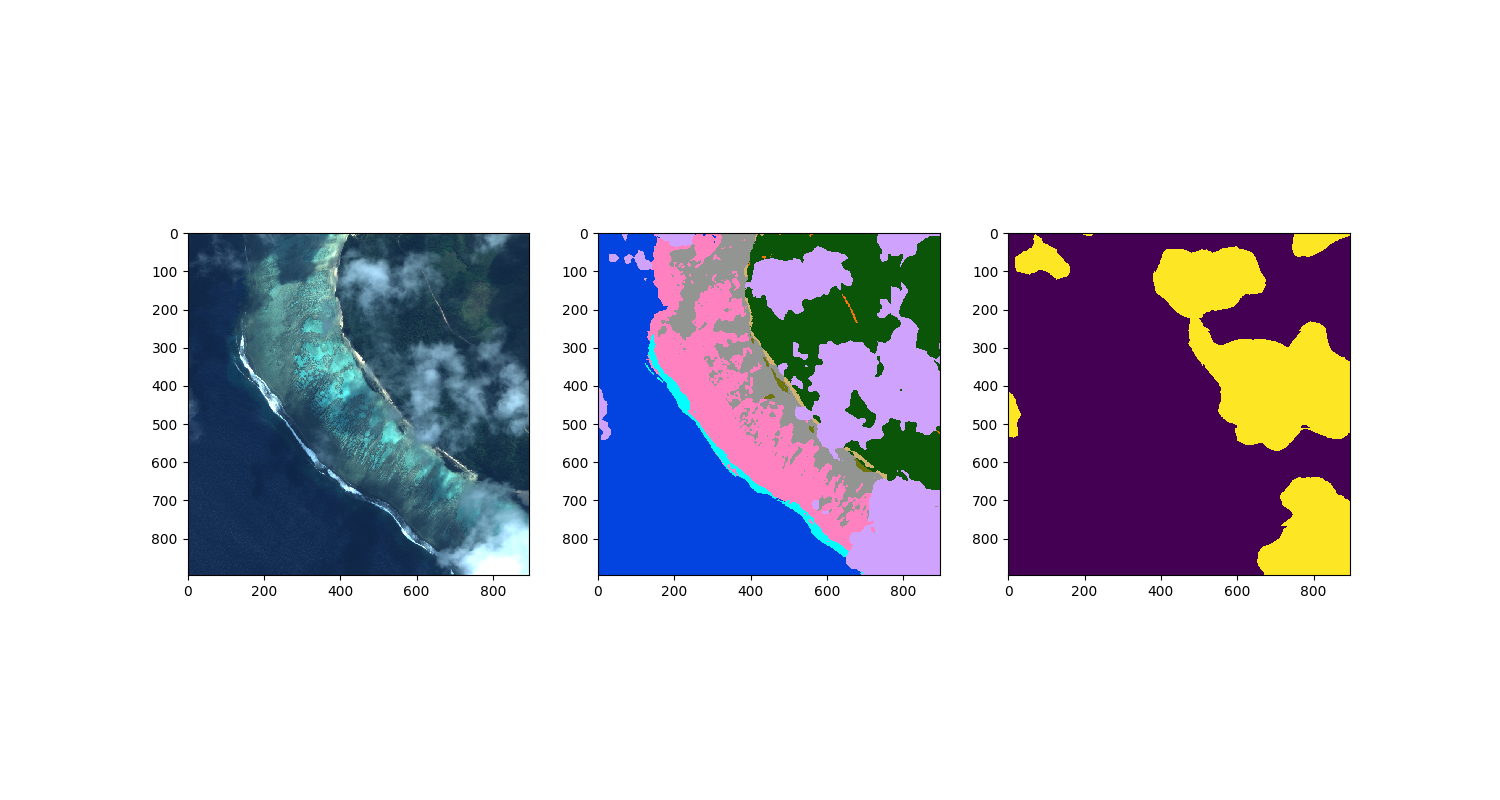

In [14]:
# PREDICTION TIME!
Fiji.set_mean_std(100,100)
cloud_predict, cloudnum_predict, cloudprob_predict, cloudtruth_predict, cloudaccuracy = \
    Fiji.predict_on_whole_image(cloudmodel, image_size = 256, num_classes = 3, spacing = (128,128), predict_size = 128, num_lines=None, lastchannelremove=False)
whole_predict, num_predict, prob_predict, truth_predict, accuracy = \
    Fiji.predict_on_whole_image(model, image_size = 256, num_classes = len(class_indices_rev), spacing = (128,128), predict_size = 128, num_lines=None, lastchannelremove=False)

# print(labelkey['Terrestrial vegetation'])
# DANN Code
# whole_predict = np.zeros((ylen,xlen))
# for i in range(4):
#     for j in range(4):
#         testoutput = model.predict(np.expand_dims((Fiji.testimage[j*256:(j+1)*256,i*256:(i+1)*256,:]-100)/100,axis=0))
#         whole_predict[j*256:(j+1)*256,i*256:(i+1)*256] = np.reshape(np.argmax(testoutput[0][0],-1), (256,256))

# land mask
landcover = np.where(Testtruth.astype(int) == labelkey['Terrestrial vegetation'])
for i in range(len(landcover[0])):
    temp_predict = whole_predict[landcover[0][i],landcover[1][i]].astype(int)+1
    if temp_predict != labelkey['Terrestrial vegetation'] and temp_predict != labelkey['Other or Unknown'] and temp_predict != labelkey['Clouds']:
        whole_predict[landcover[0][i],landcover[1][i]] = labelkey['Terrestrial vegetation']-1
        prob_predict[landcover[0][i],landcover[1][i],:] = 0
        prob_predict[landcover[0][i],landcover[1][i],4] = 1
        
# Cloud & shadow mask
# cloudcover = np.where()
# cloudcover = np.where(cloudprob_predict[:,:,1] >= 0.75)
# for i in range(len(cloudcover[0])):
#     whole_predict[cloudcover[0][i],cloudcover[1][i]] = labelkey['Clouds']-1
#     prob_predict[cloudcover[0][i],cloudcover[1][i],:] = 0
#     prob_predict[cloudcover[0][i],cloudcover[1][i],6] = 1

cloudcover = np.where(np.logical_and(np.equal(whole_predict.astype(int)+1,labelkey["Clouds"]), np.not_equal(cloud_predict.astype(int),1))) # Predicted as clouds in nemo-model, but not predicted as clouds using cloud model
shadowcover = np.where(cloud_predict.astype(int) == 2)
for i in range(len(shadowcover[0])):
    cloud_predict[shadowcover[0][i],shadowcover[1][i]] = 0

if len(cloudcover[0]) >= len(shadowcover[0])/2:
    for i in range(len(shadowcover[0])):
        whole_predict[shadowcover[0][i],shadowcover[1][i]] = labelkey['Other or Unknown']-1
        prob_predict[shadowcover[0][i],shadowcover[1][i],:] = 0
        prob_predict[shadowcover[0][i],shadowcover[1][i],8] = 0.5
        prob_predict[shadowcover[0][i],shadowcover[1][i],:8] = 0.5/8 


fig = plt.figure(10,figsize=(15,8))
ax = plt.subplot(131)
plt.imshow(Fiji_RGB[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart,:])

ax = plt.subplot(132)
ax.imshow(whole_predict.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)

ax = plt.subplot(133)
ax.imshow(cloud_predict.astype(int)+1)
plt.show()




KL-divergence at 0: -6665129.120521275
KL-divergence at 1: -7471101.381859242
KL-divergence at 2: -7579382.255067456
KL-divergence at 3: -7605116.302820145
KL-divergence at 4: -7613934.52184537
KL-divergence at 5: -7618288.652488128
KL-divergence at 6: -7621089.848407283
KL-divergence at 7: -7623243.455495193
KL-divergence at 8: -7624908.886015509
KL-divergence at 9: -7626258.730681159
KL-divergence at 10: -7627395.634451465
KL-divergence at 11: -7628432.418535528
KL-divergence at 12: -7629313.331555673
KL-divergence at 13: -7630149.931447291
KL-divergence at 14: -7630973.369489279
KL-divergence at 15: -7631667.597790353
KL-divergence at 16: -7632175.759685063
KL-divergence at 17: -7632572.706884497
KL-divergence at 18: -7632918.6364259785
KL-divergence at 19: -7633275.108549391


<IPython.core.display.Javascript object>


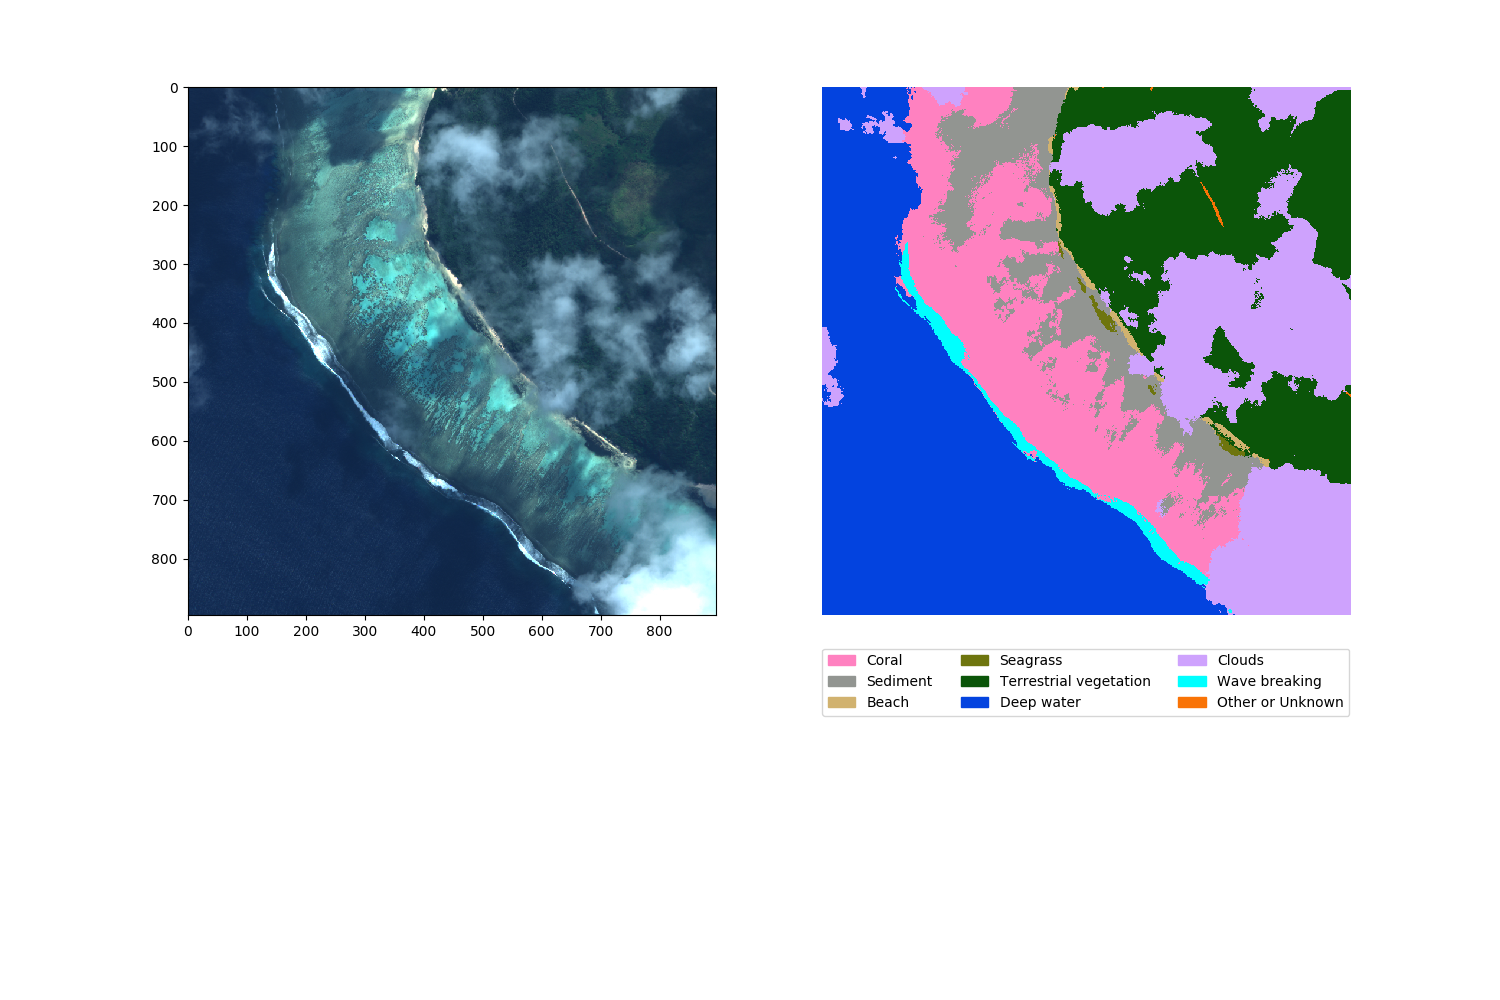

In [15]:
# Conditional random field code
import pydensecrf.densecrf as dcrf
from cv2 import imread, imwrite
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, create_pairwise_gaussian, unary_from_softmax

prob_predict_switch = np.rollaxis(prob_predict,2,0)
U = unary_from_softmax(prob_predict_switch)
d = dcrf.DenseCRF2D(xlen-2*offstart, ylen-2*offstart,len(class_indices_rev))
d.setUnaryEnergy(U)
pairwise_gaussian = create_pairwise_gaussian(sdims=(5,5), shape=whole_predict.shape[:2]) # smaller the sdims, the more important it is
d.addPairwiseEnergy(pairwise_gaussian, compat=0, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
pairwise_bilateral = create_pairwise_bilateral(sdims=(10,10), schan=3, img=Fiji.testimage[offstart:ylen-offstart,offstart:xlen-offstart], chdim=2) 
d.addPairwiseEnergy(pairwise_bilateral, compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

Q, tmp1, tmp2 = d.startInference()
for i in range(20):
    print("KL-divergence at {}: {}".format(i, d.klDivergence(Q)))
    d.stepInference(Q, tmp1, tmp2)

MAP = np.argmax(Q, axis=0)
final_predict = np.reshape(MAP, (ylen-2*offstart, xlen-2*offstart))
# accuracy = 100*np.asarray((final_predict == Testtruth_consolidated)).astype(np.float32).sum()/(whole_predict.shape[0]*whole_predict.shape[1])
# print(accuracy)

fig = plt.figure(6,figsize=(15,10))
ax = plt.subplot(121)
ax.imshow(Fiji_RGB[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart])
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])

ax = plt.subplot(122)
ax.imshow(final_predict.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])
ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(len(cmap_Ved.colors))],
           ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)
ax.set_axis_off()
plt.show()

{'Coral': 1, 'Sediment': 2, 'Beach': 3, 'Seagrass': 4, 'Terrestrial vegetation': 5, 'Deep water': 6, 'Clouds': 7, 'Wave breaking': 8, 'Other or Unknown': 9}
# of high prob sediment:  25643
# of high prob corals:  31292
# of high prob seagrass:  592
# of high prob clouds:  139474
# of high prob ocean:  241552


<IPython.core.display.Javascript object>


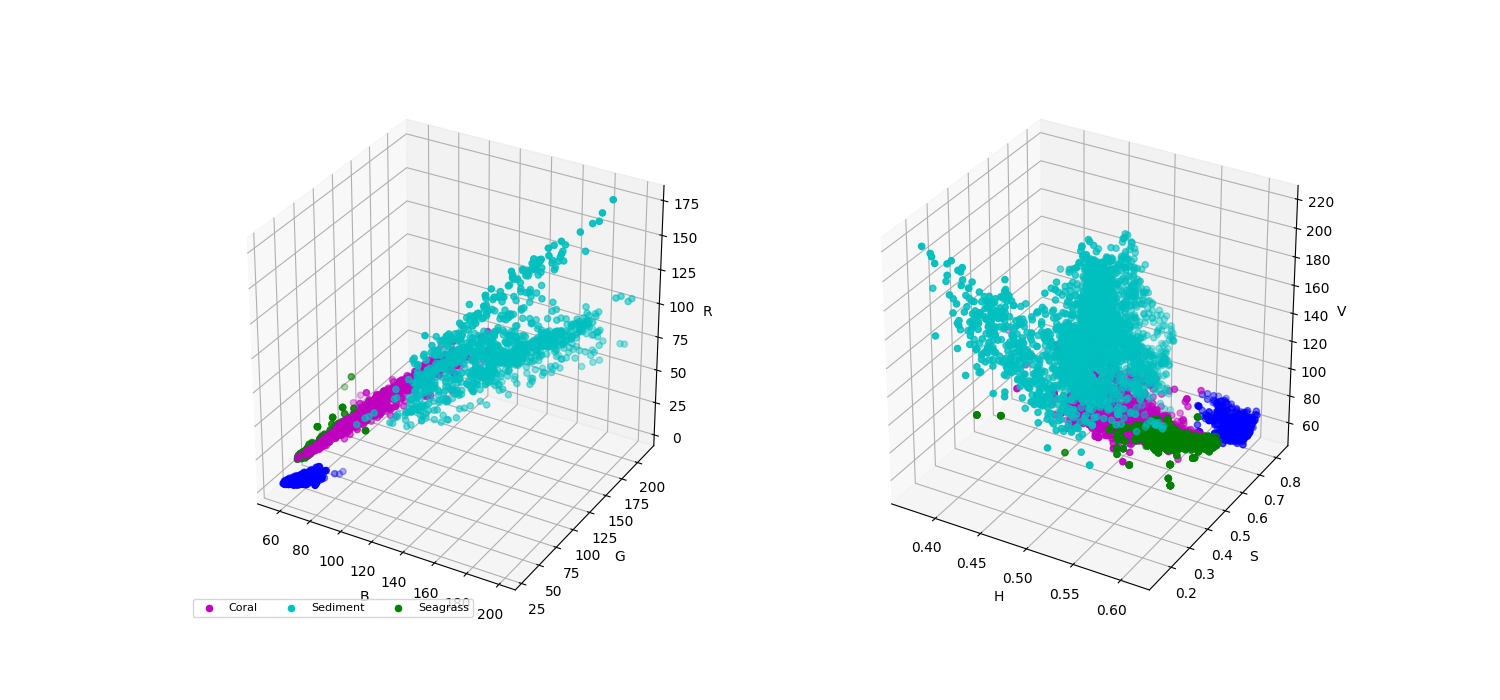

[-1  0]


<IPython.core.display.Javascript object>


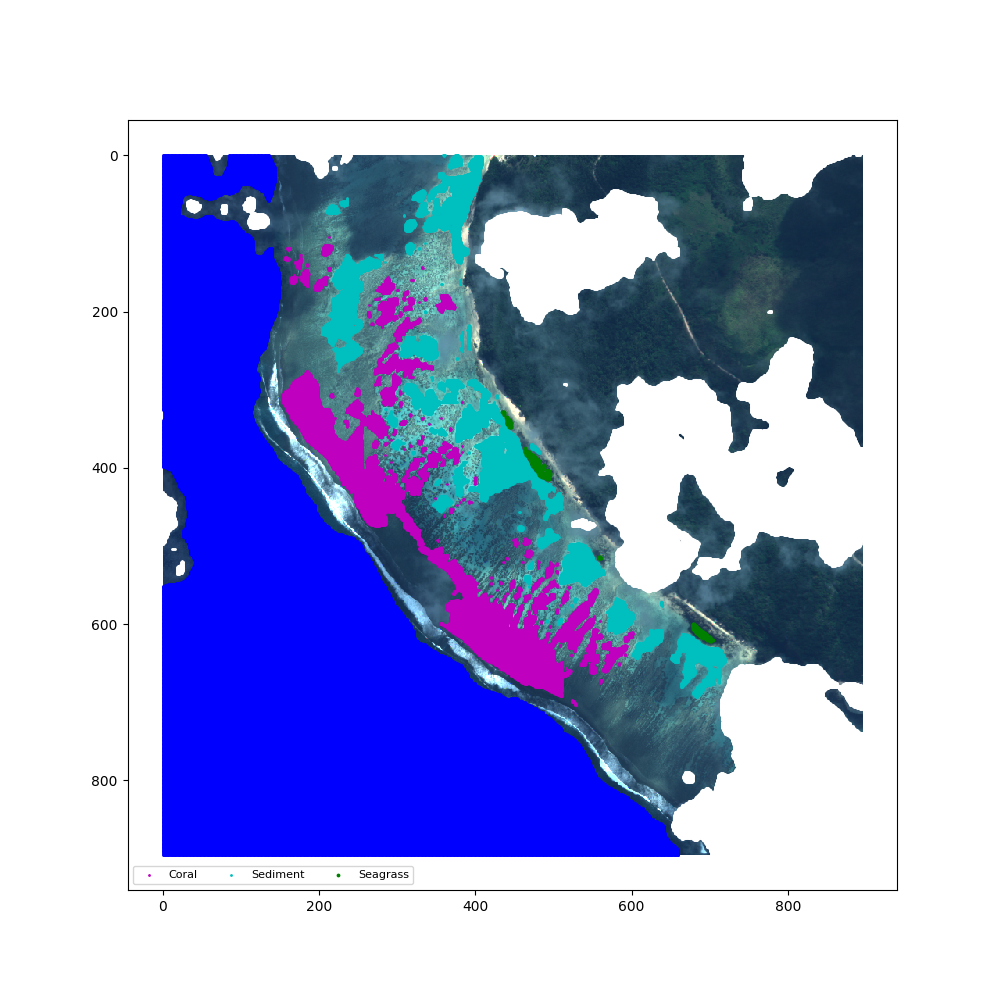

Coral statistics:  [89.03742282 79.00590502 47.2901656  17.76501112] [12.61889917 16.88952531 12.07403964  5.74007694]
Sediment statistics:  [141.24335081 143.18738371  79.20829366  16.45392193] [20.87410264 25.77087419 19.97070044 13.91770729]


<IPython.core.display.Javascript object>


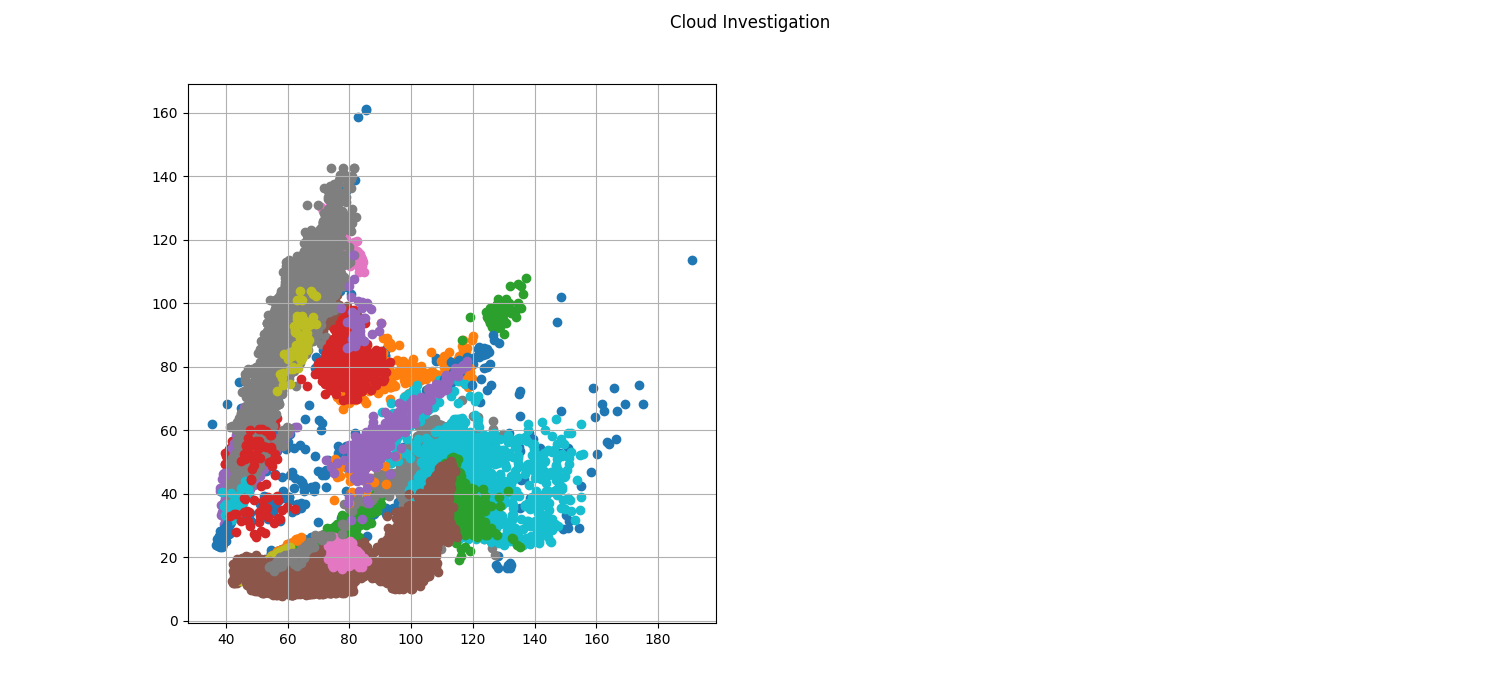

Cloud cluster  -1 :  [93.96734826 81.03211455 57.28817077 50.03226213] [24.29422539 32.2749924  29.25895072 24.9767453 ]
Cloud cluster  0 :  [84.26750333 59.72817135 37.82106767 23.20619079] [2.56951232 2.58313809 2.23502246 1.66524851]
Cloud cluster  0  is in coral cluster
Cloud cluster  1 :  [93.68430604 73.49968385 44.93710421 25.32651746] [9.20758028 9.02187853 8.05039704 7.7181383 ]
Cloud cluster  1  is in coral cluster
Cloud cluster  2 :  [60.63654521 46.332374   24.15879421 51.60532079] [2.2656102  2.60642344 2.42538827 5.74975398]
Cloud cluster  3 :  [62.99283573 46.93983872 24.50987551 48.16509643] [ 4.44400807  5.32599887  4.51214579 12.50597921]
Cloud cluster  4 :  [84.02010172 72.45474329 45.51087731 98.14588482] [7.03982662 5.6637201  5.39290403 4.6747734 ]
Cloud cluster  5 :  [ 88.13943296  77.3642092   48.36270448 120.77013459] [4.06155431 3.20818718 3.1723725  5.47858233]
Cloud cluster  6 :  [66.74970956 59.76461135 38.70382057 87.67053525] [ 4.24315908  9.01178879  9.3

In [16]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from skimage.color import rgb2hsv
from sklearn.cluster import KMeans, DBSCAN
from sklearn import svm
from sklearn import neighbors

# There is still confusion between coral and sediment to a degree... we can fine tune it
print(labelkey)
n=3000
n_sg_cutoff = 300
Fiji_HSV = rgb2hsv(Fiji.testimage[offstart:ylen-offstart,offstart:xlen-offstart,2::-1])

sediment = np.where(final_predict.astype(int)+1 == labelkey['Sediment'])
sediment_highprob = np.where(prob_predict[:,:,1] >= 0.9)
print("# of high prob sediment: ", len(sediment_highprob[0]))
randomsed = np.random.randint(len(sediment_highprob[0]), size=n)
randomsed_hsv = Fiji_HSV[sediment_highprob[0][randomsed],sediment_highprob[1][randomsed],:]
randomsed = Fiji.testimage[offstart+sediment_highprob[0][randomsed],offstart+sediment_highprob[1][randomsed],:]

coralprob_cutoff = 0.9
corals = np.where(final_predict.astype(int)+1 == labelkey['Coral'])
corals_highprob = np.where(prob_predict[:,:,0] >= coralprob_cutoff)
while len(corals_highprob[0]) >= 0.75*len(sediment_highprob[0]) and coralprob_cutoff <= 0.95:
    coralprob_cutoff = coralprob_cutoff + 0.01
    corals_highprob = np.where(prob_predict[:,:,0] >= coralprob_cutoff)
while len(corals_highprob[0]) <= 0.7*len(sediment_highprob[0]) and coralprob_cutoff >= 0.5:
    coralprob_cutoff = coralprob_cutoff - 0.01
    corals_highprob = np.where(prob_predict[:,:,0] >= coralprob_cutoff)
print("# of high prob corals: ", len(corals_highprob[0]))
randomcorals = np.random.randint(len(corals_highprob[0]), size=n)
randomcorals_hsv = Fiji_HSV[corals_highprob[0][randomcorals],corals_highprob[1][randomcorals],:]
randomcorals = Fiji.testimage[offstart+corals_highprob[0][randomcorals],offstart+corals_highprob[1][randomcorals],:]

seagrass = np.where(final_predict.astype(int)+1 == labelkey['Seagrass'])
seagrass_highprob = np.where(prob_predict[:,:,3] >= 0.75)
print("# of high prob seagrass: ", len(seagrass_highprob[0]))
if len(seagrass_highprob[0]) >= n_sg_cutoff:
    randomsg = np.random.randint(len(seagrass_highprob[0]), size=n)
    randomsg_hsv = Fiji_HSV[seagrass_highprob[0][randomsg],seagrass_highprob[1][randomsg],:]
    randomsg = Fiji.testimage[offstart+seagrass_highprob[0][randomsg],offstart+seagrass_highprob[1][randomsg],:]

# clouds = np.where(final_predict.astype(int)+1 == labelkey['Clouds'])
clouds = np.where(np.logical_and(np.equal(final_predict.astype(int)+1,labelkey["Clouds"]), np.not_equal(cloud_predict.astype(int),1))) # Predicted as clouds in nemo-model, but not predicted as clouds using cloud model
clouds_highprob = np.where(prob_predict[:,:,6] >= 0.85)
print("# of high prob clouds: ", len(clouds_highprob[0]))
if len(clouds_highprob[0]) >= 100:
    randomclouds = np.random.randint(len(clouds_highprob[0]), size=n)
    randomclouds = Fiji.testimage[offstart+clouds_highprob[0][randomclouds], offstart+clouds_highprob[1][randomclouds],:]
    
ocean = np.where(final_predict.astype(int)+1 == labelkey['Deep water'])
ocean_highprob = np.where(prob_predict[:,:,5] >= 0.9)
print("# of high prob ocean: ", len(ocean_highprob[0]))
if len(ocean_highprob[0]) >= 100:
    randomocean = np.random.randint(len(ocean_highprob[0]), size=n)
    randomocean_hsv = Fiji_HSV[ocean_highprob[0][randomocean], ocean_highprob[1][randomocean],:]
    randomocean = Fiji.testimage[offstart+ocean_highprob[0][randomocean], offstart+ocean_highprob[1][randomocean],:]
    
# plot 3d scatterplot
nscatter = 1000
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(121, projection='3d')
coral_scatter = ax.scatter(randomcorals[:nscatter,0], randomcorals[:nscatter,1], randomcorals[:nscatter,2], c='m',marker='o')
sediment_scatter = ax.scatter(randomsed[:nscatter,0], randomsed[:nscatter,1], randomsed[:nscatter,2], c='c',marker='o')
ocean_scatter = ax.scatter(randomocean[:nscatter,0], randomocean[:nscatter,1], randomocean[:nscatter,3], c='b', marker='o')
if len(seagrass_highprob[0]) >= n_sg_cutoff:
    seagrass_scatter = ax.scatter(randomsg[:nscatter,0], randomsg[:nscatter,1], randomsg[:nscatter,2], c='g',marker='o')
    plt.legend((coral_scatter, sediment_scatter, seagrass_scatter), ('Coral', 'Sediment', 'Seagrass'),scatterpoints=1,loc='lower left',ncol=3,fontsize=8)
else:
    plt.legend((coral_scatter, sediment_scatter), ('Coral', 'Sediment'),scatterpoints=1,loc='lower left',ncol=3,fontsize=8)
# if len(clouds_highprob[0]) >= 100:
#     ax.scatter(randomclouds[:,0], randomclouds[:,1], randomclouds[:,2], c='k', marker='o')
ax.set_xlabel('B')
ax.set_ylabel('G')
ax.set_zlabel('R')

ax = fig.add_subplot(122, projection='3d')
ax.scatter(randomcorals_hsv[:,0], randomcorals_hsv[:,1], randomcorals_hsv[:,2], c='m',marker='o')
ax.scatter(randomsed_hsv[:,0], randomsed_hsv[:,1], randomsed_hsv[:,2], c='c',marker='o')
ax.scatter(randomocean_hsv[:,0], randomocean_hsv[:,1], randomocean_hsv[:,2], c='b', marker='o')
if len(seagrass_highprob[0]) >= 100:
    ax.scatter(randomsg_hsv[:,0], randomsg_hsv[:,1], randomsg_hsv[:,2], c='g',marker='o')
ax.set_xlabel('H')
ax.set_ylabel('S')
ax.set_zlabel('V')
plt.show()

# KNN classification algorithm between coral, sediment, (seagrass), ocean
combineALL = np.concatenate((randomcorals[:,:], randomsed[:,:]), axis=0)
y = np.concatenate((np.zeros(n,), np.ones(n,)), axis=0)
numcombine = 2
combineidx = {"Coral":0, "Sediment":1}
if len(seagrass_highprob[0]) >= n_sg_cutoff:
    combineALL = np.concatenate((combineALL[:,:],randomsg[:,:]), axis=0)
    y = np.concatenate((y, numcombine*np.ones(n,)), axis=0)
    combineidx["Seagrass"] = numcombine
    numcombine = numcombine+1
if len(ocean_highprob[0]) >= 100:
    combineALL = np.concatenate((combineALL[:,:],randomocean[:,:]), axis=0)
    y = np.concatenate((y, numcombine*np.ones(n,)), axis=0)
    combineidx["Ocean"] = numcombine
    numcombine = numcombine+1
clf_all = neighbors.KNeighborsClassifier(10,weights='distance')
clf_all.fit(combineALL,y)

if len(clouds_highprob[0]) >= 100:
    clustering = DBSCAN(eps=5, min_samples=20).fit(Fiji.testimage[offstart+clouds_highprob[0], offstart+clouds_highprob[1],:])
    uniquelabels = np.unique(clustering.labels_)
print(uniquelabels)

fig = plt.figure(figsize=(10,10))
plt.imshow(Fiji_RGB[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart])
coral_scatter = plt.scatter(y=corals_highprob[0], x=corals_highprob[1], c='m', s=1)
sediment_scatter = plt.scatter(y=sediment_highprob[0], x=sediment_highprob[1], c='c', s=1)
ocean_scatter = plt.scatter(y=ocean_highprob[0], x=ocean_highprob[1], c='b', s=1)
if len(seagrass_highprob[0]) >= n_sg_cutoff:
    seagrass_scatter = plt.scatter(y=seagrass_highprob[0], x=seagrass_highprob[1], c='g', s=3)
    plt.legend((coral_scatter, sediment_scatter, seagrass_scatter), ('Coral', 'Sediment', 'Seagrass'),scatterpoints=1,loc='lower left',ncol=3,fontsize=8)
else:
    plt.legend((coral_scatter, sediment_scatter), ('Coral', 'Sediment'), scatterpoints=1,loc='lower left',ncol=3,fontsize=8)
if len(clouds_highprob[0] >= 100):
    plt.scatter(y=clouds_highprob[0], x=clouds_highprob[1], c='w', s=1)
plt.show()

coral_mean = np.mean(Fiji.testimage[offstart+corals_highprob[0], offstart+corals_highprob[1],:], 0)
coral_std = np.std(Fiji.testimage[offstart+corals_highprob[0], offstart+corals_highprob[1],:], 0)
sediment_mean = np.mean(Fiji.testimage[offstart+sediment_highprob[0], offstart+sediment_highprob[1],:], 0)
sediment_std = np.std(Fiji.testimage[offstart+sediment_highprob[0], offstart+sediment_highprob[1],:], 0)
print("Coral statistics: ", coral_mean, coral_std)
print("Sediment statistics: ", sediment_mean, sediment_std)

# Cloud Study
if len(clouds_highprob[0]) >= 100:
    cloudsX = []
    cloudsY = []
    clustermeans = []
    
    # DBSCAN to identify clusters of cloud-predicted pixels
    
    coordinates = 2*np.stack((offstart+clouds[0], offstart+clouds[1]), axis=-1)
    spec_and_coord = np.concatenate((Fiji.testimage[offstart+clouds[0], offstart+clouds[1],:], coordinates), axis=-1)
    
    clustering_all = DBSCAN(eps=15, min_samples=20).fit(spec_and_coord)
    uniquelabels_all = np.unique(clustering_all.labels_)
    
    # Plot clusters of cloud predicted pixels using DBSCAN
    fig = plt.figure(figsize=(15,7))
    fig.suptitle('Cloud Investigation')
    ax = fig.add_subplot(121)
    cloud_repredict_list = []
    for l in uniquelabels_all:
        tempclass = np.where(clustering_all.labels_ == l)
        ax.scatter(Fiji.testimage[offstart+clouds[0][tempclass], offstart+clouds[1][tempclass],1], Fiji.testimage[offstart+clouds[0][tempclass], offstart+clouds[1][tempclass],3])
        cloudcluster_mean = np.mean(Fiji.testimage[offstart+clouds[0][tempclass], offstart+clouds[1][tempclass]],0)
        cloudcluster_std = np.std(Fiji.testimage[offstart+clouds[0][tempclass], offstart+clouds[1][tempclass]],0)
        print("Cloud cluster ", l, ": ", cloudcluster_mean, cloudcluster_std)
        if all((cloudcluster_mean >= sediment_mean-2*sediment_std) & (cloudcluster_mean <=sediment_mean+2*sediment_std)) and l >= 0 :
            print("Cloud cluster ", l, " is in sediment cluster")
            cloud_repredict_list.append(l)
        if all((cloudcluster_mean >= coral_mean-2*coral_std) & (cloudcluster_mean <=coral_mean+2*coral_std)) and l >= 0:
            print("Cloud cluster ", l, " is in coral cluster")
            cloud_repredict_list.append(l)
    plt.grid()
    plt.show()
    
print(cloud_repredict_list)

<IPython.core.display.Javascript object>


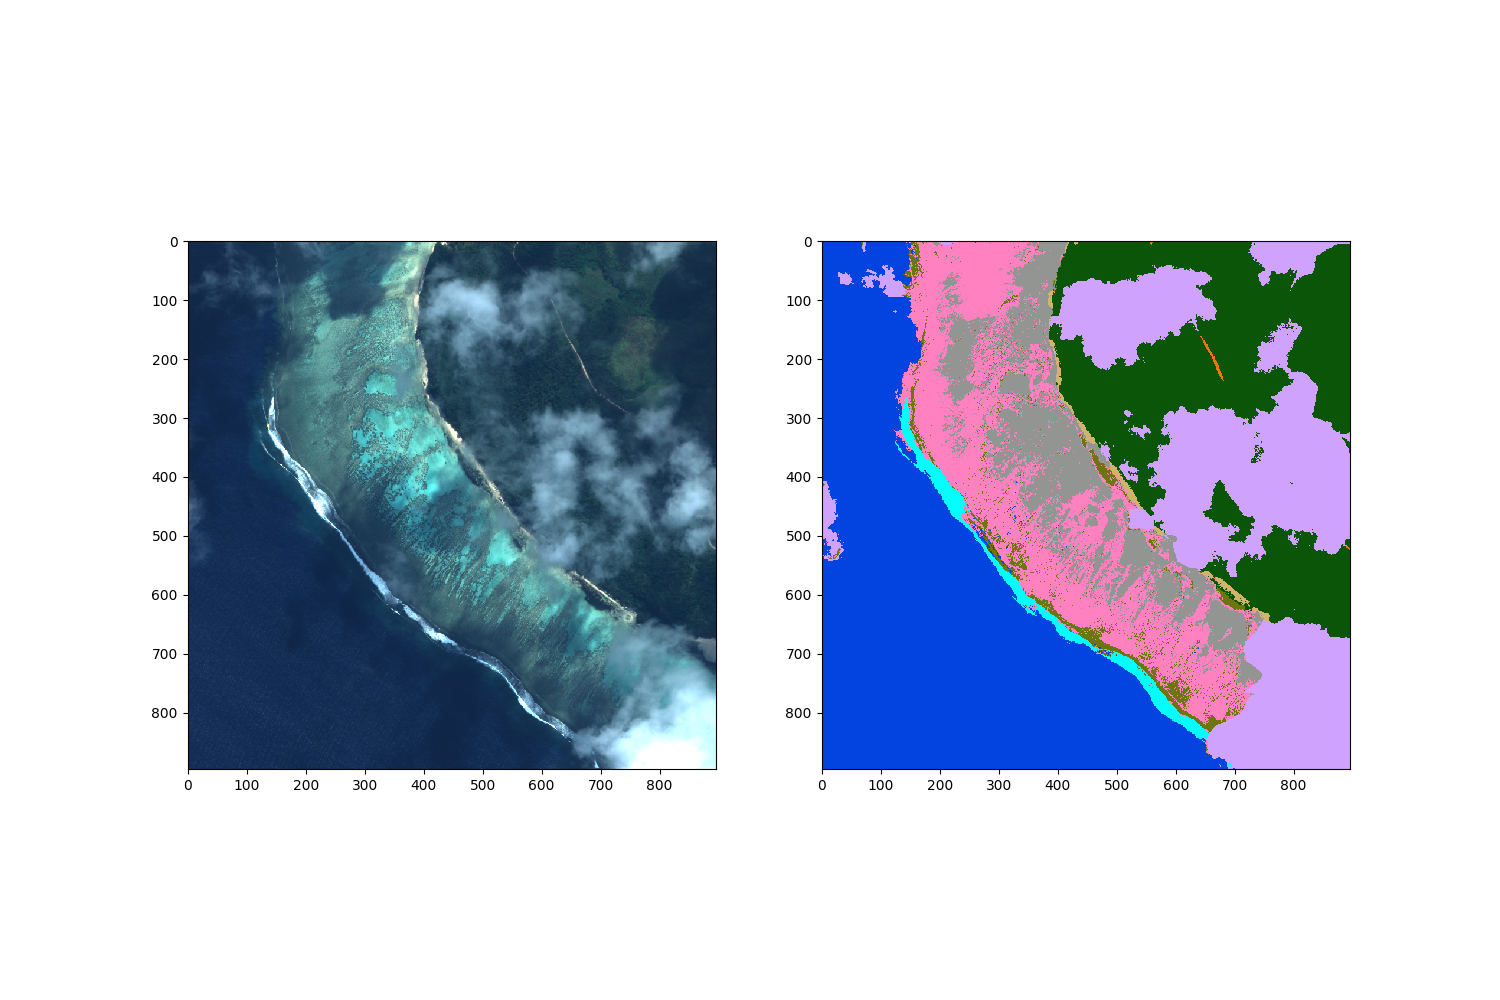

In [17]:
coralidx = 0
sedimentidx = 1
seagrassidx = 3
oceanidx = 5
svm_predict = np.copy(final_predict)
svm_predict_prob = np.copy(prob_predict)

totalcorals = Fiji.testimage[offstart+corals[0][:], offstart+corals[1][:], :]
totalcorals_predict = clf_all.predict(totalcorals)
totalcorals_predictprob = clf_all.predict_proba(totalcorals)

totalsediment = Fiji.testimage[offstart+sediment[0][:],offstart+sediment[1][:], :]
totalsediment_predict = clf_all.predict(totalsediment)
totalsediment_predictprob = clf_all.predict_proba(totalsediment)

if len(seagrass_highprob[0]) >= n_sg_cutoff:
    totalseagrass = Fiji.testimage[offstart+seagrass[0][:], offstart+seagrass[1][:], :]
    totalseagrass_predict = clf_all.predict(totalseagrass)
    totalseagrass_predictprob = clf_all.predict_proba(totalseagrass)

if len(clouds_highprob[0]) >= 100:
    totalclouds = Fiji.testimage[offstart+clouds[0][:], offstart+clouds[1][:],:]
#     totalclouds_predict = clf_clouds.predict(totalclouds)
#     totalclouds_predictprob = clf_clouds.predict_proba(totalclouds)
    for i in range(len(clouds[0])):
        if clustering_all.labels_[i] in cloud_repredict_list:
            repredict_clouds = clf_all.predict(np.expand_dims(totalclouds[i], axis=0))
            repredictprob_clouds = clf_all.predict_proba(np.expand_dims(totalclouds[i], axis=0))
            if repredict_clouds[0] == combineidx["Coral"]:
                svm_predict[clouds[0][i],clouds[1][i]] = coralidx
            elif repredict_clouds[0] == combineidx["Sediment"]:
                svm_predict[clouds[0][i],clouds[1][i]] = sedimentidx
            if len(seagrass_highprob[0]) >= 100:
                if repredict_clouds[0] == combineidx["Seagrass"]:
                    svm_predict[clouds[0][i],clouds[1][i]] = seagrassidx
                svm_predict_prob[clouds[0][i],clouds[1][i],seagrassidx] = repredictprob_clouds[0][combineidx["Seagrass"]]
            svm_predict_prob[clouds[0][i],clouds[1][i],:] = 0
            svm_predict_prob[clouds[0][i],clouds[1][i],coralidx] = repredictprob_clouds[0][combineidx["Coral"]]
            svm_predict_prob[clouds[0][i],clouds[1][i],sedimentidx] = repredictprob_clouds[0][combineidx["Sediment"]]
            svm_predict_prob[clouds[0][i],clouds[1][i],oceanidx] = repredictprob_clouds[0][combineidx["Ocean"]]

for i in range(len(corals[0])):
    svm_predict_prob[corals[0][i],corals[1][i],:] = 0
    if totalcorals_predict[i] == combineidx["Coral"]:
        svm_predict[corals[0][i],corals[1][i]] = coralidx
    elif totalcorals_predict[i] == combineidx["Sediment"]:
        svm_predict[corals[0][i],corals[1][i]] = sedimentidx
    elif totalcorals_predict[i] == combineidx["Ocean"]:
        svm_predict[corals[0][i],corals[1][i]] = oceanidx
    if len(seagrass_highprob[0]) >= n_sg_cutoff:
        if totalcorals_predict[i] == combineidx["Seagrass"]:
            svm_predict[corals[0][i],corals[1][i]] = seagrassidx
        svm_predict_prob[corals[0][i],corals[1][i],seagrassidx] = totalcorals_predictprob[i][combineidx["Seagrass"]]

    svm_predict_prob[corals[0][i],corals[1][i],coralidx] = totalcorals_predictprob[i][combineidx["Coral"]]
    svm_predict_prob[corals[0][i],corals[1][i],sedimentidx] = totalcorals_predictprob[i][combineidx["Sediment"]]
    svm_predict_prob[corals[0][i],corals[1][i],oceanidx] = totalcorals_predictprob[i][combineidx["Ocean"]]

        
for i in range(len(sediment[0])):
    svm_predict_prob[sediment[0][i],sediment[1][i],:] = 0
    if totalsediment_predict[i] == combineidx["Coral"]:
        svm_predict[sediment[0][i],sediment[1][i]] = coralidx
    elif totalsediment_predict[i] == combineidx["Sediment"]:
        svm_predict[sediment[0][i],sediment[1][i]] = sedimentidx
    if len(seagrass_highprob[0]) >= n_sg_cutoff:
        if totalsediment_predict[i] == combineidx["Seagrass"]:
            svm_predict[sediment[0][i],sediment[1][i]] = seagrassidx
        svm_predict_prob[sediment[0][i],sediment[1][i],seagrassidx] = totalsediment_predictprob[i][combineidx["Seagrass"]]
        
    svm_predict_prob[sediment[0][i],sediment[1][i],coralidx] = totalsediment_predictprob[i][combineidx["Coral"]]
    svm_predict_prob[sediment[0][i],sediment[1][i],sedimentidx] = totalsediment_predictprob[i][combineidx["Sediment"]]
    svm_predict_prob[sediment[0][i],sediment[1][i],oceanidx] = totalsediment_predictprob[i][combineidx["Ocean"]]

if len(seagrass_highprob[0]) >= n_sg_cutoff:
    for i in range(len(seagrass[0])):
        if totalseagrass_predict[i] == combineidx["Coral"]:
            svm_predict[seagrass[0][i],seagrass[1][i]] = coralidx
        elif totalseagrass_predict[i] == combineidx["Sediment"]:
            svm_predict[seagrass[0][i],seagrass[1][i]] = sedimentidx
        elif totalseagrass_predict[i] == combineidx["Seagrass"]:
            svm_predict[seagrass[0][i],seagrass[1][i]] = seagrassidx
        svm_predict_prob[seagrass[0][i],seagrass[1][i],:] = 0
        svm_predict_prob[seagrass[0][i],seagrass[1][i],coralidx] = totalseagrass_predictprob[i][combineidx["Coral"]]
        svm_predict_prob[seagrass[0][i],seagrass[1][i],sedimentidx] = totalseagrass_predictprob[i][combineidx["Sediment"]]
        svm_predict_prob[seagrass[0][i],seagrass[1][i],seagrassidx] = totalseagrass_predictprob[i][combineidx["Seagrass"]]
        svm_predict_prob[seagrass[0][i],seagrass[1][i],oceanidx] = totalseagrass_predictprob[i][combineidx["Ocean"]]
    
                
fig = plt.figure(figsize=(15,10))
ax = plt.subplot(121)
ax.imshow(Fiji_RGB[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart])
# ax.scatter(y=corals_highprob[0], x=corals_highprob[1], c='m', s=1)
# ax.scatter(y=sediment_highprob[0], x=sediment_highprob[1], c='c', s=1)
# ax.scatter(y=seagrass_highprob[0], x=seagrass_highprob[1], c='g', s=1)

ax = plt.subplot(122)
ax.imshow(svm_predict.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)
plt.show()

KL-divergence at 0: -7539100.118129975
KL-divergence at 1: -8161883.2474733405
KL-divergence at 2: -8229987.413674011
KL-divergence at 3: -8245465.038914854
KL-divergence at 4: -8252445.2086190265
KL-divergence at 5: -8257065.949106913
KL-divergence at 6: -8260214.429473058
KL-divergence at 7: -8262631.51298991
KL-divergence at 8: -8264893.069866933
KL-divergence at 9: -8266837.007004154
KL-divergence at 10: -8268462.058118095
KL-divergence at 11: -8269762.253341042
KL-divergence at 12: -8270744.46217794
KL-divergence at 13: -8271466.673064675
KL-divergence at 14: -8272082.236740239
KL-divergence at 15: -8272636.782962222
KL-divergence at 16: -8273165.760650286
KL-divergence at 17: -8273651.2133969255
KL-divergence at 18: -8274108.144122018
KL-divergence at 19: -8274562.55870998


<IPython.core.display.Javascript object>


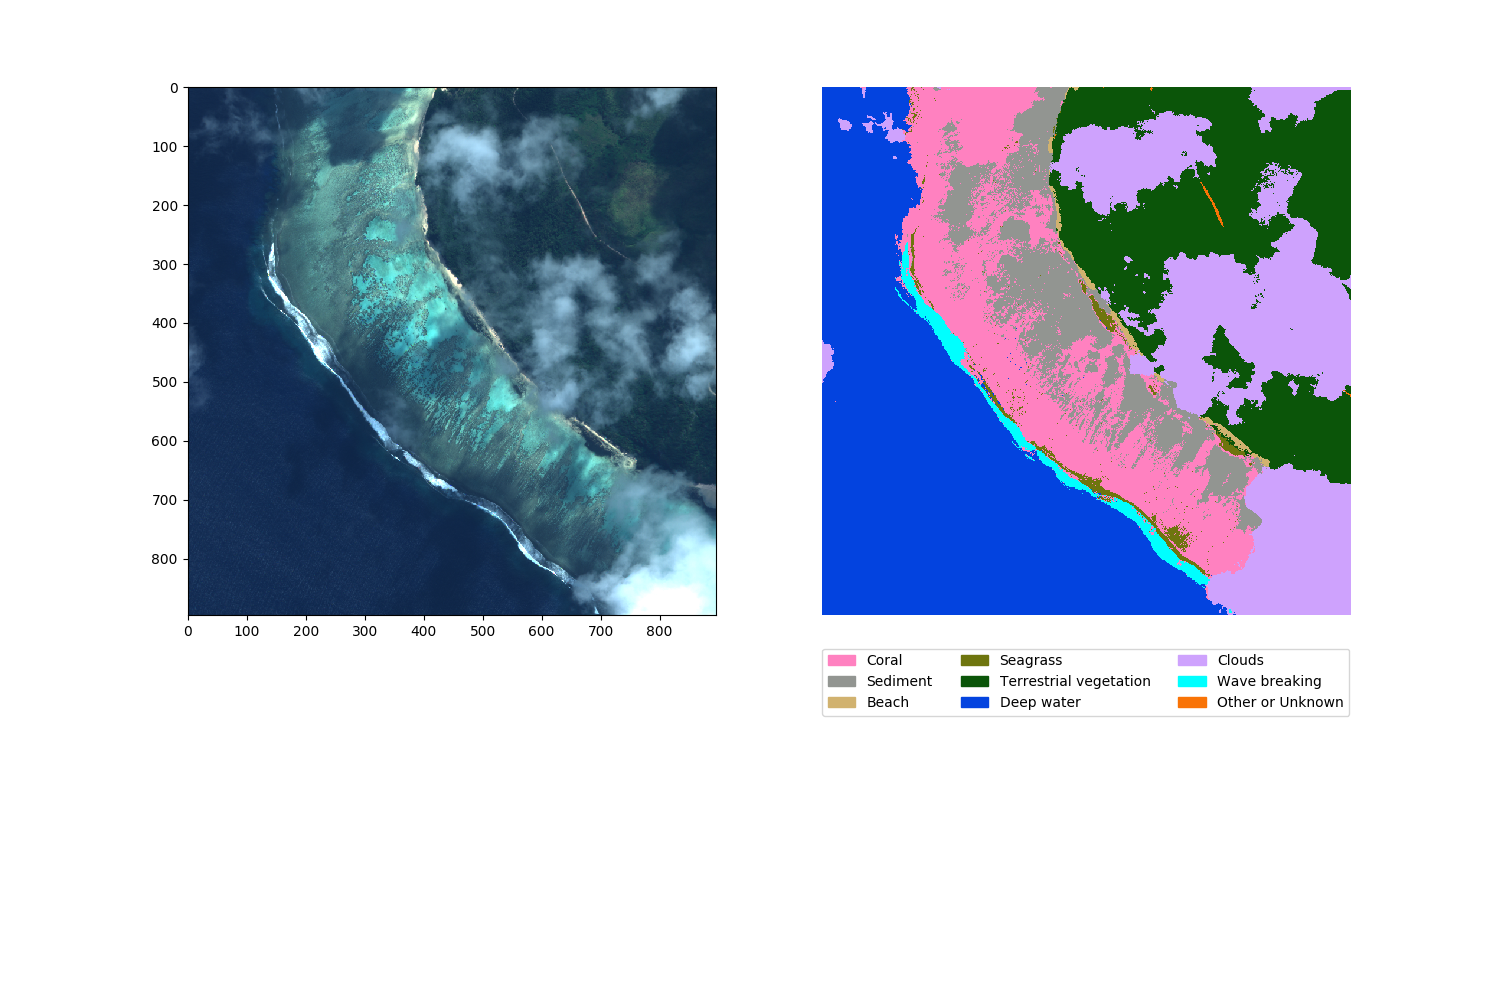

In [18]:
prob_predict_switch_trans = np.rollaxis(svm_predict_prob,2,0)
U = unary_from_softmax(prob_predict_switch_trans)
d = dcrf.DenseCRF2D(xlen-2*offstart, ylen-2*offstart,len(class_indices_rev))
d.setUnaryEnergy(U)
pairwise_gaussian = create_pairwise_gaussian(sdims=(3,3), shape=whole_predict.shape[:2]) # smaller the sdims, the more important it is
d.addPairwiseEnergy(pairwise_gaussian, compat=1, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
pairwise_bilateral = create_pairwise_bilateral(sdims=(25,25), schan=3, img=Fiji.testimage[offstart:ylen-offstart,offstart:xlen-offstart], chdim=2) 
d.addPairwiseEnergy(pairwise_bilateral, compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

Q, tmp1, tmp2 = d.startInference()
for i in range(20):
    print("KL-divergence at {}: {}".format(i, d.klDivergence(Q)))
    d.stepInference(Q, tmp1, tmp2)

MAP = np.argmax(Q, axis=0)
final_predict_svm = np.reshape(MAP, (ylen-2*offstart, xlen-2*offstart))

fig = plt.figure(figsize=(15,10))
ax = plt.subplot(121)
ax.imshow(Fiji_RGB[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart])
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])

ax = plt.subplot(122)
ax.imshow(final_predict_svm.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])
ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(len(cmap_Ved.colors))],
           ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)
ax.set_axis_off()
plt.show()

In [325]:
# tempcloudmask = final_predict.astype(int)+10*cloud_predict.astype(int)
# clouds = np.where(np.logical_and(np.greater_equal(tempcloudmask,10), np.less_equal(tempcloudmask,20)))
# clouds = np.where(np.logical_and(np.equal(final_predict.astype(int)+1,labelkey["Clouds"]), np.not_equal(cloud_predict.astype(int),1)))
# print(clouds)
print(Fiji.testimage[311,458])



[71.75165558 56.43468857 36.97412491 42.03208542]


<IPython.core.display.Javascript object>


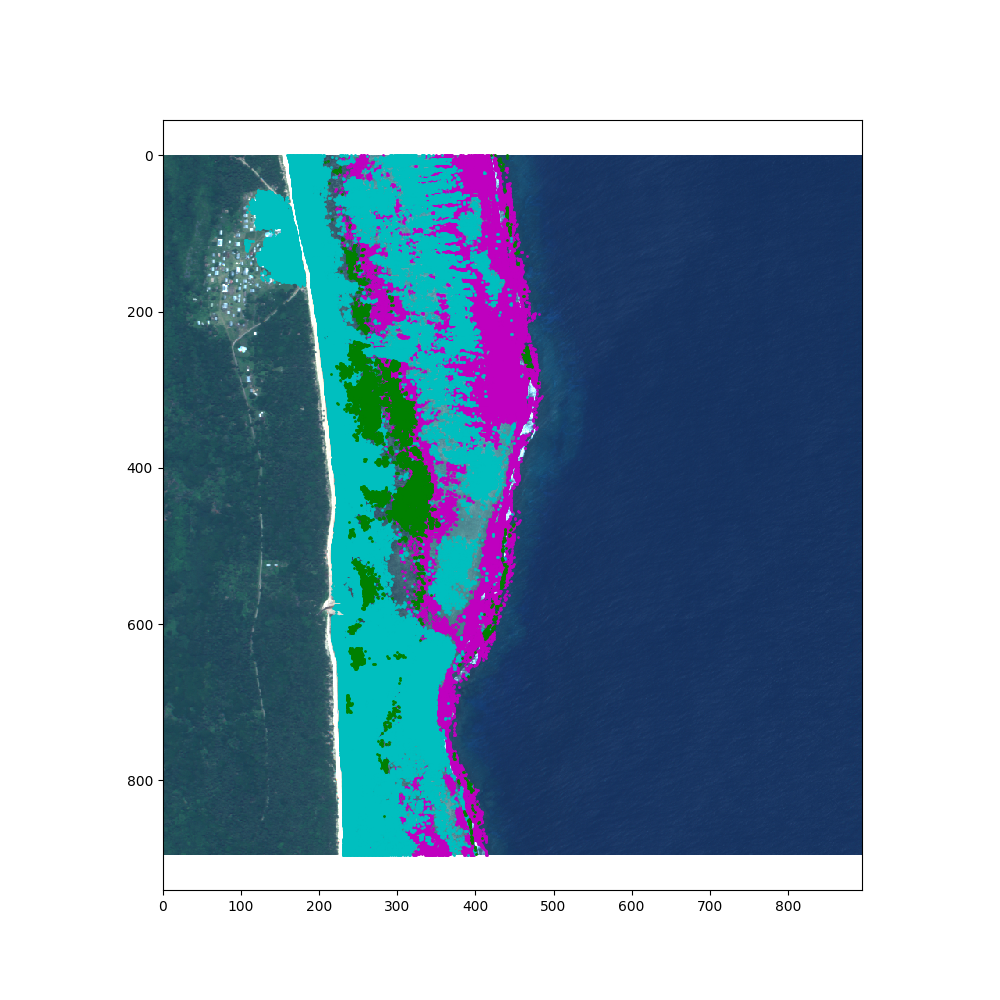

In [185]:
# Q_predict = np.swapaxes(np.reshape(np.asarray(Q), (-1,ylen-2*offstart, xlen-2*offstart)),0,2)
# Q_predict = np.swapaxes(Q_predict,0,1)
Q_predict = svm_predict_prob;

Qcorals = np.where(final_predict_svm.astype(int)+1 == labelkey['Coral'])
Qcorals_highprob = np.where(Q_predict[:,:,0] >= 0.99)
Qrandomcorals = np.random.randint(len(Qcorals_highprob[0]), size=n)
Qrandomcorals = Fiji.testimage[offstart+Qcorals_highprob[0][Qrandomcorals],offstart+Qcorals_highprob[1][Qrandomcorals],:]

Qsediment = np.where(final_predict_svm.astype(int)+1 == labelkey['Sediment'])
Qsediment_highprob = np.where(Q_predict[:,:,1] >= 0.99)
Qrandomsed = np.random.randint(len(Qsediment_highprob[0]), size=n)
Qrandomsed = Fiji.testimage[offstart+Qsediment_highprob[0][Qrandomsed],offstart+Qsediment_highprob[1][Qrandomsed],:]

Qseagrass = np.where(final_predict_svm.astype(int)+1 == labelkey['Seagrass'])
Qseagrass_highprob = np.where(Q_predict[:,:,3] >= 0.99)
Qrandomsg = np.random.randint(len(Qseagrass_highprob[0]), size=n)
Qrandomsg = Fiji.testimage[offstart+Qseagrass_highprob[0][Qrandomsg],offstart+Qseagrass_highprob[1][Qrandomsg],:]


fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)
ax.imshow(Fiji_RGB[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart])
ax.scatter(y=Qcorals_highprob[0], x=Qcorals_highprob[1], c='m', s=1)
ax.scatter(y=Qsediment_highprob[0], x=Qsediment_highprob[1], c='c', s=1)
ax.scatter(y=Qseagrass_highprob[0], x=Qseagrass_highprob[1], c='g', s=1)
plt.show()


In [ ]:
# putting image through polynomial fit before into CNN again (doesn't work all that well)

Cicia_orig_file = '/home/shared/NeMO-Net Data/processed_Fiji_files/mosaiced_001.TIF'
Cicia_orig_truth = '/home/shared/NeMO-Net Data/KSLOF-CICIA-FIJI/Cicia_Satellite_image_mosaic_KSLOF.tif'
jsonpath = './utils/CoralClasses.json'
with open(jsonpath) as json_file:
    json_data = json.load(json_file)
Cicia_orig = coralutils.CoralData(Cicia_orig_file, Truthpath=Cicia_orig_truth, truth_key=json_data["Fiji_ClassDict"], load_type="raster")

xstart_orig = 3100
xlen = 512
ystart_orig = 600
ylen = 512

offset = 128
xstart_orig = xstart_orig+offset
ystart_orig = ystart_orig+offset

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
Testimage1 = Cicia_orig.image[ystart_orig:ystart_orig+ylen,xstart_orig:xstart_orig+xlen,:]
Testimage1_RGB = 255/200*np.rollaxis(np.asarray([Testimage1[:,:,4], Testimage1[:,:,2], Testimage1[:,:,1]]),0,3)
Testimage1_RGB[Testimage1_RGB > 255] = 255
Testimage1_RGB = np.asarray(Testimage1_RGB, dtype=np.uint8)
ax.imshow(Testimage1_RGB)

sg_ystart_orig = 305
sg_xstart_orig = 70
sg_ylen = 20
sg_xlen = 20

sed_ystart_orig = 132
sed_xstart_orig = 220
sed_ylen = 20
sed_xlen = 20

coral_ystart_orig = 80
coral_xstart_orig = 185
coral_ylen = 20
coral_xlen = 20

sample_sg_pts_orig = Cicia_orig.image[ystart_orig+sg_ystart_orig:ystart_orig+sg_ystart_orig+sg_ylen, xstart_orig+sg_xstart_orig:xstart_orig+sg_xstart_orig+sg_xlen, :]
sample_sed_pts_orig = Cicia_orig.image[ystart_orig+sed_ystart_orig:ystart_orig+sed_ystart_orig+sed_ylen, xstart_orig+sed_xstart_orig:xstart_orig+sed_xstart_orig+sed_xlen, :]
sample_coral_pts_orig = Cicia_orig.image[ystart_orig+coral_ystart_orig:ystart_orig+coral_ystart_orig+coral_ylen, xstart_orig+coral_xstart_orig:xstart_orig+coral_xstart_orig+coral_xlen, :]

fig,ax = plt.subplots(1,4)
fig.suptitle('Comparison of spectral points')
fig.set_figheight(4)
fig.set_figwidth(16)
ax[0].scatter(randomsg[:,0], sample_sg_pts_orig[:,:,1].flatten(), c='b',marker='o')
ax[0].scatter(randomsed[:,0], sample_sed_pts_orig[:,:,1].flatten(),c='b',marker='x')
ax[0].scatter(randomcorals[:,0], sample_coral_pts_orig[:,:,1].flatten(),c='b',marker='+')
ax[0].axis('equal')
ax[0].grid()

ax[1].scatter(randomsg[:,1], sample_sg_pts_orig[:,:,2].flatten(), c='g',marker='o')
ax[1].scatter(randomsed[:,1], sample_sed_pts_orig[:,:,2].flatten(), c='g',marker='x')
ax[1].scatter(randomcorals[:,1], sample_coral_pts_orig[:,:,2].flatten(), c='g',marker='+')
ax[1].axis('equal')
ax[1].grid()

ax[2].scatter(randomsg[:,2], sample_sg_pts_orig[:,:,4].flatten(), c='r',marker='o')
ax[2].scatter(randomsed[:,2], sample_sed_pts_orig[:,:,4].flatten(), c='r',marker='x')
ax[2].scatter(randomcorals[:,2], sample_coral_pts_orig[:,:,4].flatten(), c='r',marker='+')
ax[2].axis('equal')
ax[2].grid()

ax[3].scatter(randomsg[:,3], sample_sg_pts_orig[:,:,6].flatten(), c='k',marker='o')
ax[3].scatter(randomsed[:,3], sample_sed_pts_orig[:,:,6].flatten(), c='k',marker='x')
ax[3].scatter(randomcorals[:,3], sample_coral_pts_orig[:,:,6].flatten(), c='k',marker='+')
ax[3].axis('equal')
ax[3].grid()
plt.show()

from scipy.optimize import curve_fit

def func(X, k1, k2, k3, k4, k5, k6, k7, k8, k9):
    b, g, r, n = X
    a = k1*b**2 + k2*b + k3*r**2 + k4*r + k5*g**2 + k6*g + k7*n**2 + k8*n + k9
    return a

def func_noNIR(X, k1, k2, k3, k4, k5, k6, k7):
    b, g, r= X
    a = k1*b**2 + k2*b + k3*r**2 + k4*r + k5*g**2 + k6*g + k7
    return a

def func_simple(x, k1, k2, k3):
    a = k1*x**2 + k2*x + k3
    return a

# baseline
b = np.asarray([sample_sg_pts_orig[:,:,1].flatten(), sample_sed_pts_orig[:,:,1].flatten(), sample_coral_pts_orig[:,:,1].flatten()]).flatten()
g = np.asarray([sample_sg_pts_orig[:,:,2].flatten(), sample_sed_pts_orig[:,:,2].flatten(), sample_coral_pts_orig[:,:,2].flatten()]).flatten()
r = np.asarray([sample_sg_pts_orig[:,:,4].flatten(), sample_sed_pts_orig[:,:,4].flatten(), sample_coral_pts_orig[:,:,4].flatten()]).flatten()
n = np.asarray([sample_sg_pts_orig[:,:,6].flatten(), sample_sed_pts_orig[:,:,6].flatten(), sample_coral_pts_orig[:,:,6].flatten()]).flatten()

# from predicted image
B = np.asarray([randomsg[:,0], randomsed[:,0], randomcorals[:,0]]).flatten()
G = np.asarray([randomsg[:,1], randomsed[:,1], randomcorals[:,1]]).flatten()
R = np.asarray([randomsg[:,2], randomsed[:,2], randomcorals[:,2]]).flatten()
N = np.asarray([randomsg[:,3], randomsed[:,3], randomcorals[:,3]]).flatten()

k_guess = 1,1,1,1,1,1,1,1,1
k_guess_noNIR = 1,1,1,1,1,1,1
k_guess_simple = 1,1,1
fitb = curve_fit(func_noNIR, (B,G,R), b, k_guess_noNIR)
fitg = curve_fit(func_noNIR, (B,G,R), g, k_guess_noNIR)
fitr = curve_fit(func_noNIR, (B,G,R), r, k_guess_noNIR)
fitb_simple = curve_fit(func_simple, (B), b, k_guess_simple)
fitg_simple = curve_fit(func_simple, (G), g, k_guess_simple)
fitr_simple = curve_fit(func_simple, (R), r, k_guess_simple)
fitn = curve_fit(func_simple, N, n, k_guess_simple)
print(fitb[0], fitg[0], fitr[0])
print(fitn[0])

TransitionImage = np.copy(Fiji.testimage)
totalb = np.asarray(TransitionImage[:,:,0].flatten())
totalg = np.asarray(TransitionImage[:,:,1].flatten())
totalr = np.asarray(TransitionImage[:,:,2].flatten())
totaln = np.asarray(TransitionImage[:,:,3].flatten())
white_pixels = np.where(np.sqrt(totalb**2+totalg**2+totalr**2) >= 250)
NIR_pixels = np.where(totaln >= 50)

newB = func_noNIR((totalb,totalg,totalr), fitb[0][0], fitb[0][1], fitb[0][2], fitb[0][3], fitb[0][4], fitb[0][5], fitb[0][6]) 
newG = func_noNIR((totalb,totalg,totalr), fitg[0][0], fitg[0][1], fitg[0][2], fitg[0][3], fitg[0][4], fitg[0][5], fitg[0][6])
newR = func_noNIR((totalb,totalg,totalr), fitr[0][0], fitr[0][1], fitr[0][2], fitr[0][3], fitr[0][4], fitr[0][5], fitr[0][6])
newB[NIR_pixels[0]] = totalb[NIR_pixels[0]]
newG[NIR_pixels[0]] = totalg[NIR_pixels[0]]
newR[NIR_pixels[0]] = totalr[NIR_pixels[0]]
newB[white_pixels[0]] = totalb[white_pixels[0]]
newG[white_pixels[0]] = totalg[white_pixels[0]]
newR[white_pixels[0]] = totalr[white_pixels[0]]

newB_simple = func_simple(totalb, fitb_simple[0][0], fitb_simple[0][1], fitb_simple[0][2])
newG_simple = func_simple(totalg, fitg_simple[0][0], fitg_simple[0][1], fitg_simple[0][2])
newR_simple = func_simple(totalr, fitr_simple[0][0], fitr_simple[0][1], fitr_simple[0][2])
newB_simple[NIR_pixels[0]] = totalb[NIR_pixels[0]]
newG_simple[NIR_pixels[0]] = totalg[NIR_pixels[0]]
newR_simple[NIR_pixels[0]] = totalr[NIR_pixels[0]]
newB_simple[white_pixels[0]] = totalb[white_pixels[0]]
newG_simple[white_pixels[0]] = totalg[white_pixels[0]]
newR_simple[white_pixels[0]] = totalr[white_pixels[0]]

ylen = TransitionImage.shape[0]
xlen = TransitionImage.shape[1]
newB = newB.reshape((ylen,xlen))
newG = newG.reshape((ylen,xlen))
newR = newR.reshape((ylen,xlen))
newB_simple = newB_simple.reshape((ylen,xlen))
newG_simple = newG_simple.reshape((ylen,xlen))
newR_simple = newR_simple.reshape((ylen,xlen))

remappedCicia = 255/200*np.rollaxis(np.asarray([newR_simple,newG_simple,newB_simple]),0,3)
remappedCicia[remappedCicia > 255] = 255
remappedCicia = np.asarray(remappedCicia, dtype=np.uint8)

fig,ax = plt.subplots(1,3)
fig.suptitle('Cicia Transform')
fig.set_figheight(6)
fig.set_figwidth(20)
ax[0].imshow(Fiji_RGB[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart,:])
ax[2].imshow(remappedCicia)
plt.show()

# PREDICTION TIME!
Cicia_orig.set_mean_std(100,100)
Cicia_orig.testimage = np.rollaxis(np.asarray([newB_simple,newG_simple,newR_simple,TransitionImage[:,:,3]]),0,3)
whole_predict_trans, num_predict_trans, prob_predict_trans, truth_predict_trans, accuracy_trans = \
    Cicia_orig.predict_on_whole_image(model, image_size = 256, num_classes = len(class_indices_rev), spacing = (128,128), predict_size = 128, num_lines=None, lastchannelremove=False)

fig = plt.figure(figsize=(12,12))
ax = plt.subplot(121)
ax.imshow(whole_predict_trans.astype(int)+1, interpolation='nearest', cmap=cmap_Ved, norm=norm)

ax = plt.subplot(122)
plt.imshow(Fiji_RGB[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart,:])
plt.show()

<IPython.core.display.Javascript object>


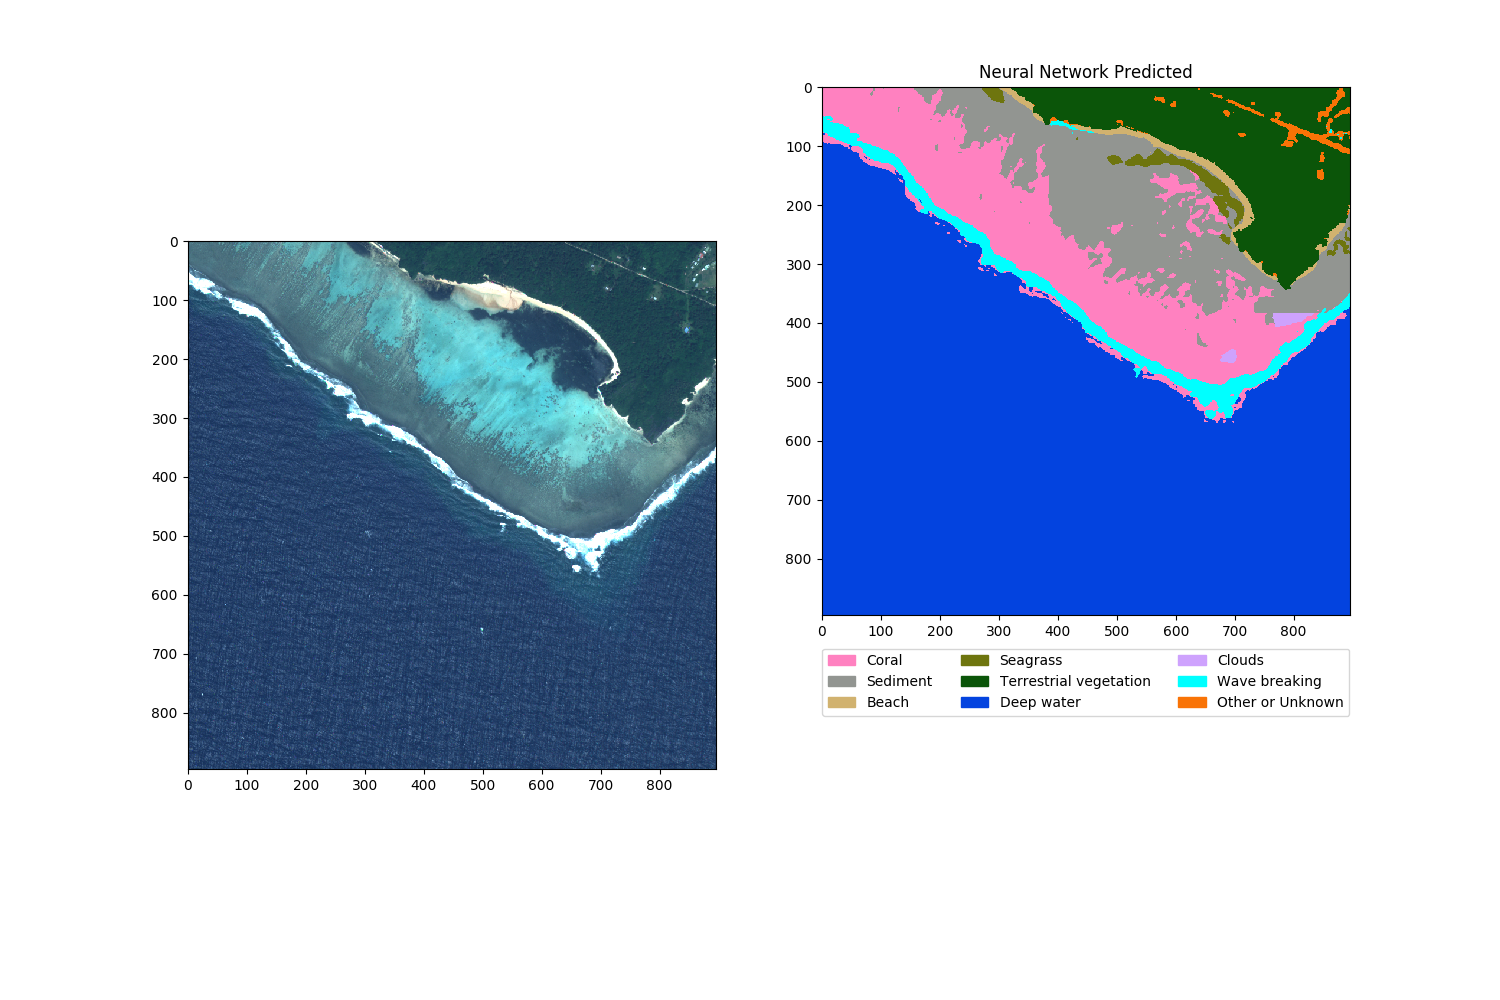

In [68]:
def MajorMask(predict_img, mask_img, prob_img, predict_labelkey, mask_labelkey):
    land = np.reshape((mask_img == mask_labelkey['Terrestrial']), (-1))
    water = np.reshape((mask_img == mask_labelkey['Deep water']), (-1))
    shallows = np.reshape((mask_img == mask_labelkey['Shallows']), (-1))
    
    original_shape = predict_img.shape
    original_prob_shape = prob_img.shape
    predict_reshape = np.reshape(np.copy(predict_img), (-1))
    prob_reshape = np.reshape(np.copy(prob_img),(-1,9))
    
    for i in range(len(predict_reshape)):
        if (land[i] == True):
            idx = 7
            sorted_idx = np.argsort(prob_reshape[i])
            while (predict_reshape[i] != predict_labelkey['Clouds']-1) and (predict_reshape[i] != predict_labelkey['Terrestrial vegetation']-1) and (predict_reshape[i] != predict_labelkey['Other or Unknown']-1):
                predict_reshape[i] = sorted_idx[idx]
                prob_reshape[i][sorted_idx[0:idx+1]] = prob_reshape[i][sorted_idx[0:idx+1]] + prob_reshape[i][sorted_idx[idx+1]]/(idx+1) #divide up probabilities amongst remaining
                prob_reshape[i][sorted_idx[idx+1]] = 0
                idx = idx-1
        elif (water[i] == True):
            idx = 7
            sorted_idx = np.argsort(prob_reshape[i])
            while (predict_reshape[i] != predict_labelkey['Clouds']-1) and (predict_reshape[i] != predict_labelkey['Deep water']-1) and (predict_reshape[i] != predict_labelkey['Other or Unknown']-1):
                predict_reshape[i] = sorted_idx[idx]
                prob_reshape[i][sorted_idx[0:idx+1]] = prob_reshape[i][sorted_idx[0:idx+1]] + prob_reshape[i][sorted_idx[idx+1]]/(idx+1)
                prob_reshape[i][sorted_idx[idx+1]] = 0
                idx = idx-1
        elif (shallows[i] == True):
            idx = 7
            sorted_idx = np.argsort(prob_reshape[i])
            while (predict_reshape[i] == predict_labelkey['Terrestrial vegetation']-1) or (predict_reshape[i] == predict_labelkey['Deep water']-1):
                predict_reshape[i] = sorted_idx[idx]
                prob_reshape[i][sorted_idx[0:idx+1]] = prob_reshape[i][sorted_idx[0:idx+1]] + prob_reshape[i][sorted_idx[idx+1]]/(idx+1)
                prob_reshape[i][sorted_idx[idx+1]] = 0
                idx = idx-1
    
    return np.reshape(predict_reshape, original_shape), np.reshape(prob_reshape, original_prob_shape)
                
cmap_Ved = colors.ListedColormap(['xkcd:pink', 'xkcd:grey', 'xkcd:tan', 'xkcd:olive', 'xkcd:forest', 'xkcd:blue',
                                'xkcd:lilac', 'xkcd:cyan', 'xkcd:orange'])
bounds = [i-0.5 for i in range(len(cmap_Ved.colors)+1)] # assumes labels start at 0
norm = colors.BoundaryNorm([b+0.5 for b in bounds], cmap_Ved.N)


whole_predict_mask, whole_predict_mask_prob = MajorMask(whole_predict, Testtruth_Major, prob_predict, json_data["VedConsolidated_ClassDict"], json_data["MajorConsolidated_ClassDict"])
# prob_predict_img = np.argmax(prob_predict,axis=2)
# prob_predict_img_mask, prob_predict_img_mask_prob = MajorMask(prob_predict_img, Testtruth_Major, prob_predict, json_data["VedConsolidated_ClassDict"], json_data["MajorConsolidated_ClassDict"])

patch_R = 255/200*Fiji.image[:,:,4]
patch_G = 255/200*Fiji.image[:,:,2]
patch_B = 255/200*Fiji.image[:,:,1]
patch_R[patch_R > 255] = 255
patch_G[patch_G > 255] = 255
patch_B[patch_B > 255] = 255
Fiji_RGB = np.rollaxis(np.asarray([patch_R, patch_G, patch_B], dtype=np.uint8),0,3)
fig = plt.figure(4,figsize=(15,10))
ax = plt.subplot(121)
ax.imshow(Fiji_RGB[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart])

ax = plt.subplot(122)
ax.imshow(whole_predict_mask, interpolation='nearest', cmap=cmap_Ved, norm=norm)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])
ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(len(cmap_Ved.colors))],
           ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)

# ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(24)], ['{}'.format(class_indices_rev[k]) for k in class_indices_rev], loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=2)
# ax.set_axis_off()
ax.set_title('Neural Network Predicted')
plt.show()


# fig = plt.figure(3,figsize=(10,10))
# ax = plt.subplot(111)
# ax.imshow(Testtruth-1, interpolation='nearest', cmap=cmap_Ved, norm=norm)
# box = ax.get_position()
# ax.set_position([box.x0, box.y0 + box.height * 0.2,
#                  box.width, box.height])
# # ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(24)],
# #               ['{}'.format(class_indices_rev[k]) for k in class_indices_rev],
# #               loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=2)
# ax.legend([mpatches.Patch(color=cmap_Ved(i)) for i in range(len(cmap_Ved.colors))],
#            ['{}'.format(class_indices_rev[i+1]) for i in range(len(class_indices_rev))],
#           loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)
# ax.set_title('ECognition Predicted')
# # ax.set_axis_off()
# # fig.savefig('Ecognition_Reference.png', bbox_inches='tight')
# plt.show()

In [157]:
# # Ocean Study: too big for dbscan
# if len(ocean_highprob[0]) >= 100:
#     # DBSCAN to identify clusters of cloud-predicted pixels
#     clustering_ocean = DBSCAN(eps=5, min_samples=20).fit(Fiji.testimage[offstart+ocean[0], offstart+ocean[1],:])
#     uniquelabels_ocean = np.unique(clustering_ocean.labels_)
    
#     ocean_repredict_list = []
#     for l in uniquelabels_ocean:
#         tempclass = np.where(clustering_ocean.labels_ == l)
#         oceancluster_mean = np.mean(Fiji.testimage[offstart+ocean[0][tempclass], offstart+ocean[1][tempclass]],0)
#         oceancluster_std = np.std(Fiji.testimage[offstart+ocean[0][tempclass], offstart+ocean[1][tempclass]],0)
#         print("Ocean cluster ", l, ": ", oceancluster_mean, oceancluster_std)
#         if all((oceancluster_mean >= sediment_mean-2*sediment_std) & (oceancluster_mean <=sediment_mean+2*sediment_std)) and l >= 0 :
#             print("Ocean cluster ", l, " is in sediment cluster")
#             ocean_repredict_list.append(l)
#         if all((oceancluster_mean >= coral_mean-2*coral_std) & (oceancluster_mean <=coral_mean+2*coral_std)) and l >= 0:
#             print("Ocean cluster ", l, " is in coral cluster")
#             ocean_repredict_list.append(l)

# coordinates = np.stack((offstart+clouds[0], offstart+clouds[1]), axis=-1)
# print(coordinates.shape)
# print(Fiji.testimage[offstart+clouds[0], offstart+clouds[1],:].shape)
# temp = np.concatenate((Fiji.testimage[offstart+clouds[0], offstart+clouds[1],:], coordinates), axis=-1)

# print(Testtruth[161,173].astype(int), labelkey['Terrestrial vegetation'])
# print(whole_predict[161,173])
print(svm_predict_prob.shape)
print(repredictprob_clouds.shape)


(896, 896, 9)
(1, 4)
